## Housekeeping Settings

In [1]:
import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, logging, seaborn as sns, pickle
from scipy.stats import median_abs_deviation, hypergeom
import multiprocessing as mp, celloracle as co, glob, pickle
from functools import reduce
from collections import Counter
import itertools, math
import networkx as nx
import random

# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/'
out_path = os.path.join(wd, 'out_data', 'comb_ctrl')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"

/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detai

# SLIDE TF Enrichment

In [2]:
# Read oracle links after fitting
oracle = co.load_hdf5(f"{wd}/out_data/grn_inference/out_files/oracle_fitted.celloracle.oracle")
links_after_fit = {key: [] for key in oracle.coef_matrix_per_cluster.keys()}
CO_TFs = []
for cluster in oracle.coef_matrix_per_cluster.keys():
    cluster_specific_links = oracle.coef_matrix_per_cluster[cluster].stack().reset_index()
    cluster_specific_links.columns = ['source', 'target', 'coef_mean']
    cluster_specific_links = cluster_specific_links[cluster_specific_links ['coef_mean'] != 0].reset_index(drop=True)
    cluster_specific_links['coef_abs'] = np.abs(cluster_specific_links['coef_mean'])
    links_after_fit[cluster] = cluster_specific_links
    # links_after_fit[cluster]['weight'] = links_after_fit[cluster]['coef_abs'] * links_after_fit[cluster]['-logp']
    CO_TFs = CO_TFs + list(links_after_fit[cluster].source.unique())

In [11]:
# Writing genes and TF for Akanksha for consistency with dictys!
# pd.DataFrame(oracle.adata.var_names).to_csv(f"{out_path}/out_files/genes.txt", index=False, header=False)
# with open(f"{out_path}/out_files/CO_TFs.txt", 'w') as f:
#     for item in list(set(CO_TFs)):
#         f.write("%s\n" % item)


Minimum weight threshold for ('3',): 0.2226148122173493
Minimum weight threshold for ('2',): 0.2385623474755033
Minimum weight threshold for ('7',): 0.191980054722947
Minimum weight threshold for ('1',): 0.2513525637427023
Minimum weight threshold for ('3',): 0.2226148122173493
Minimum weight threshold for ('2',): 0.2385623474755033
Minimum weight threshold for ('7',): 0.191980054722947
Minimum weight threshold for ('1',): 0.2513525637427023


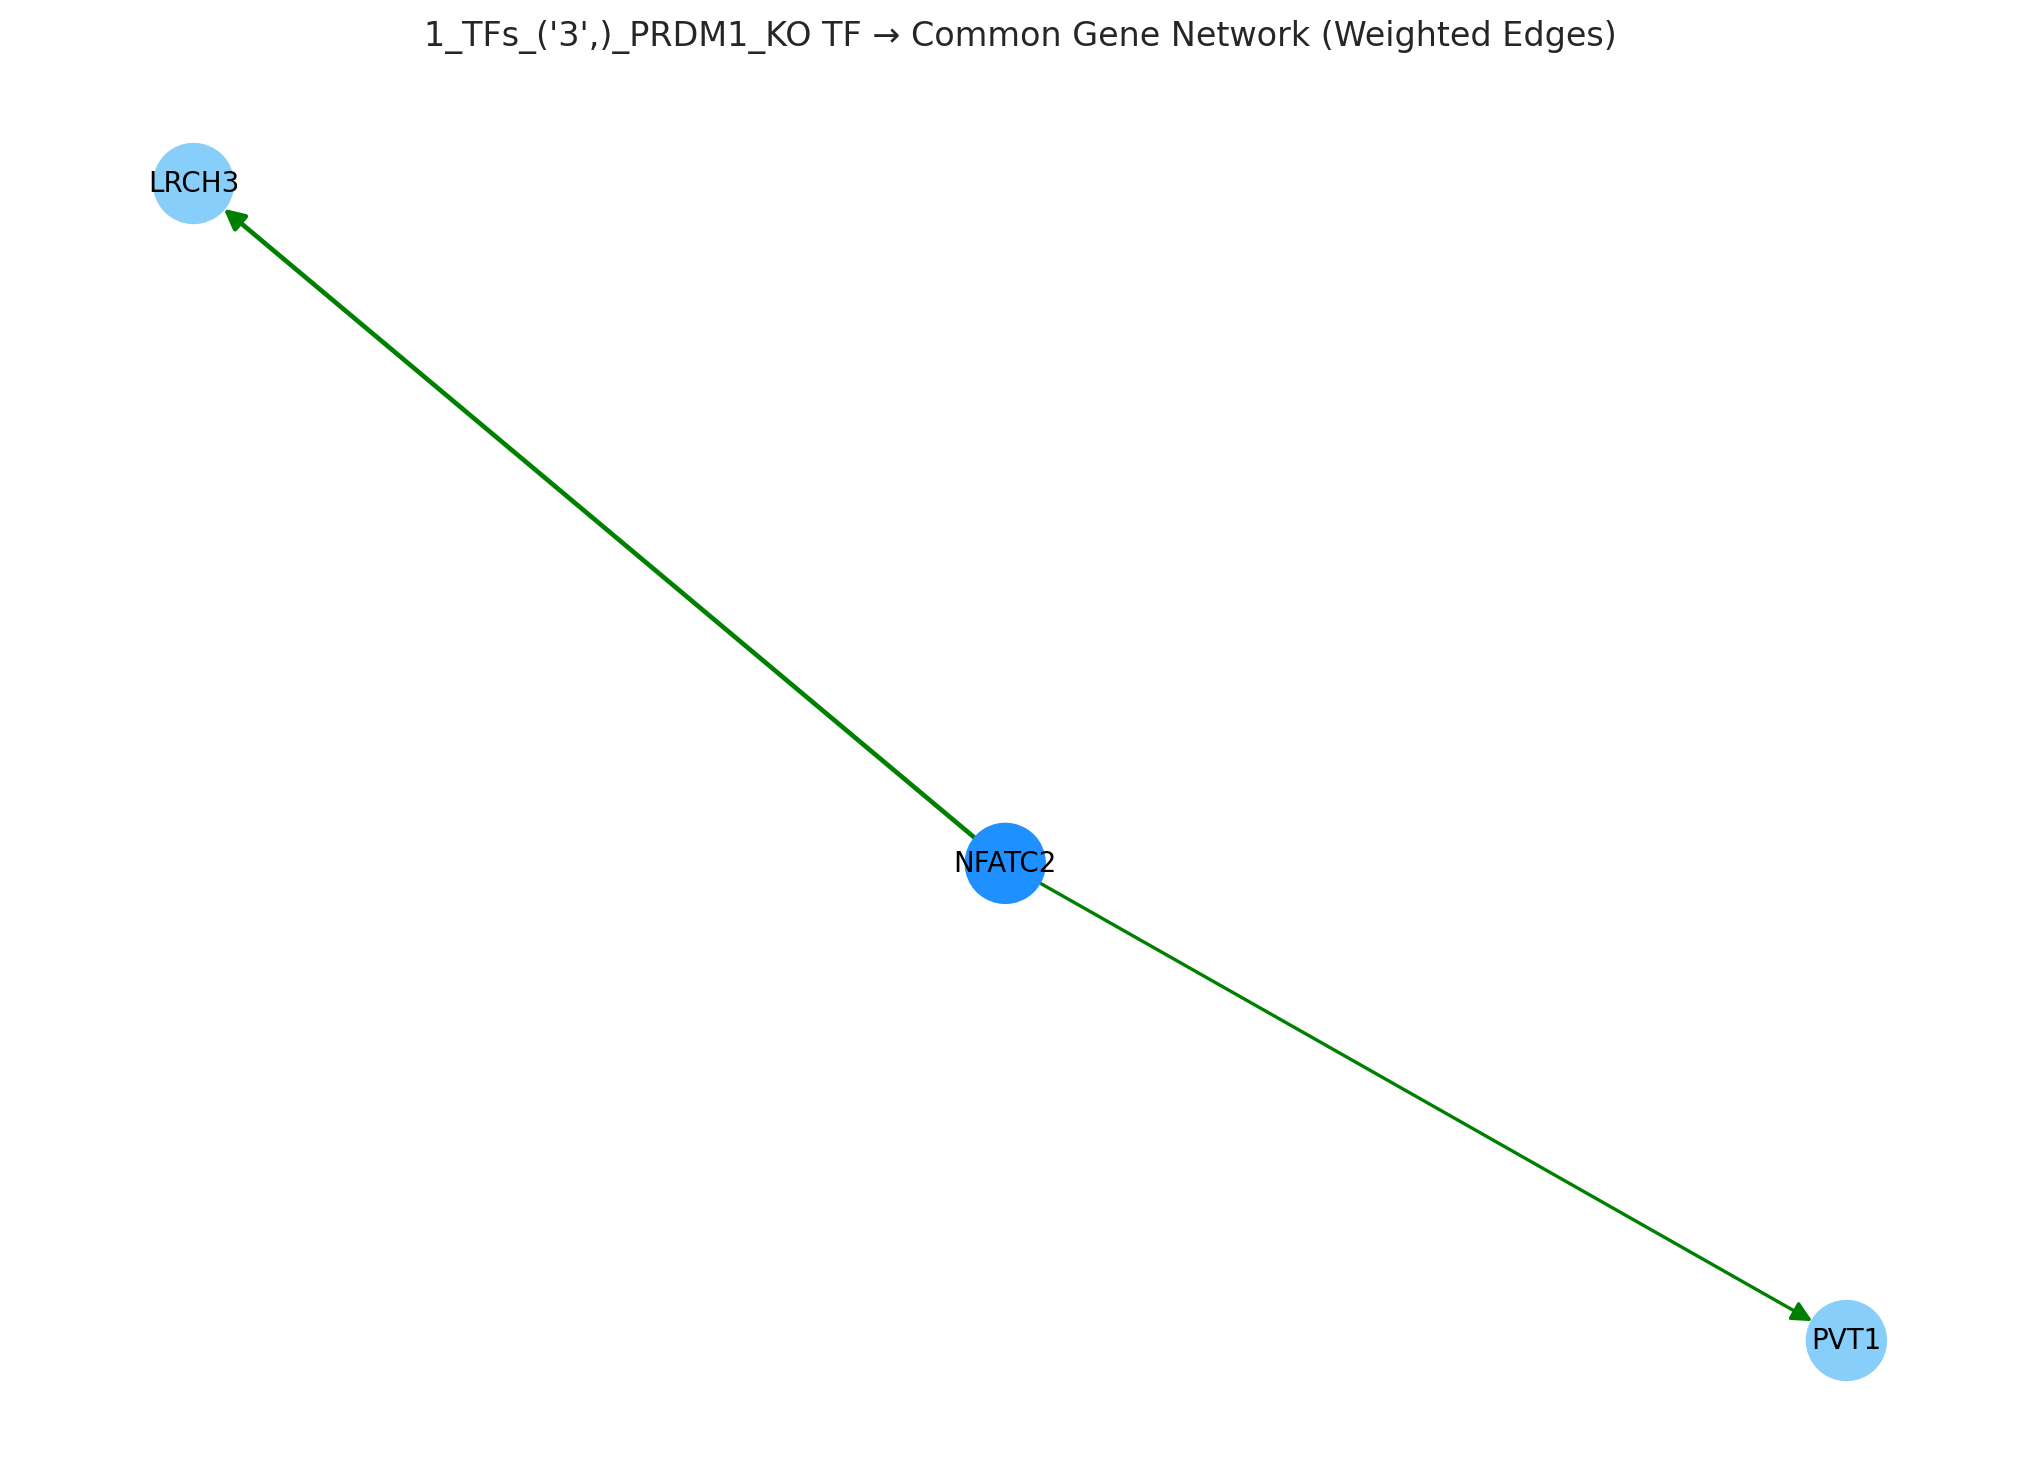

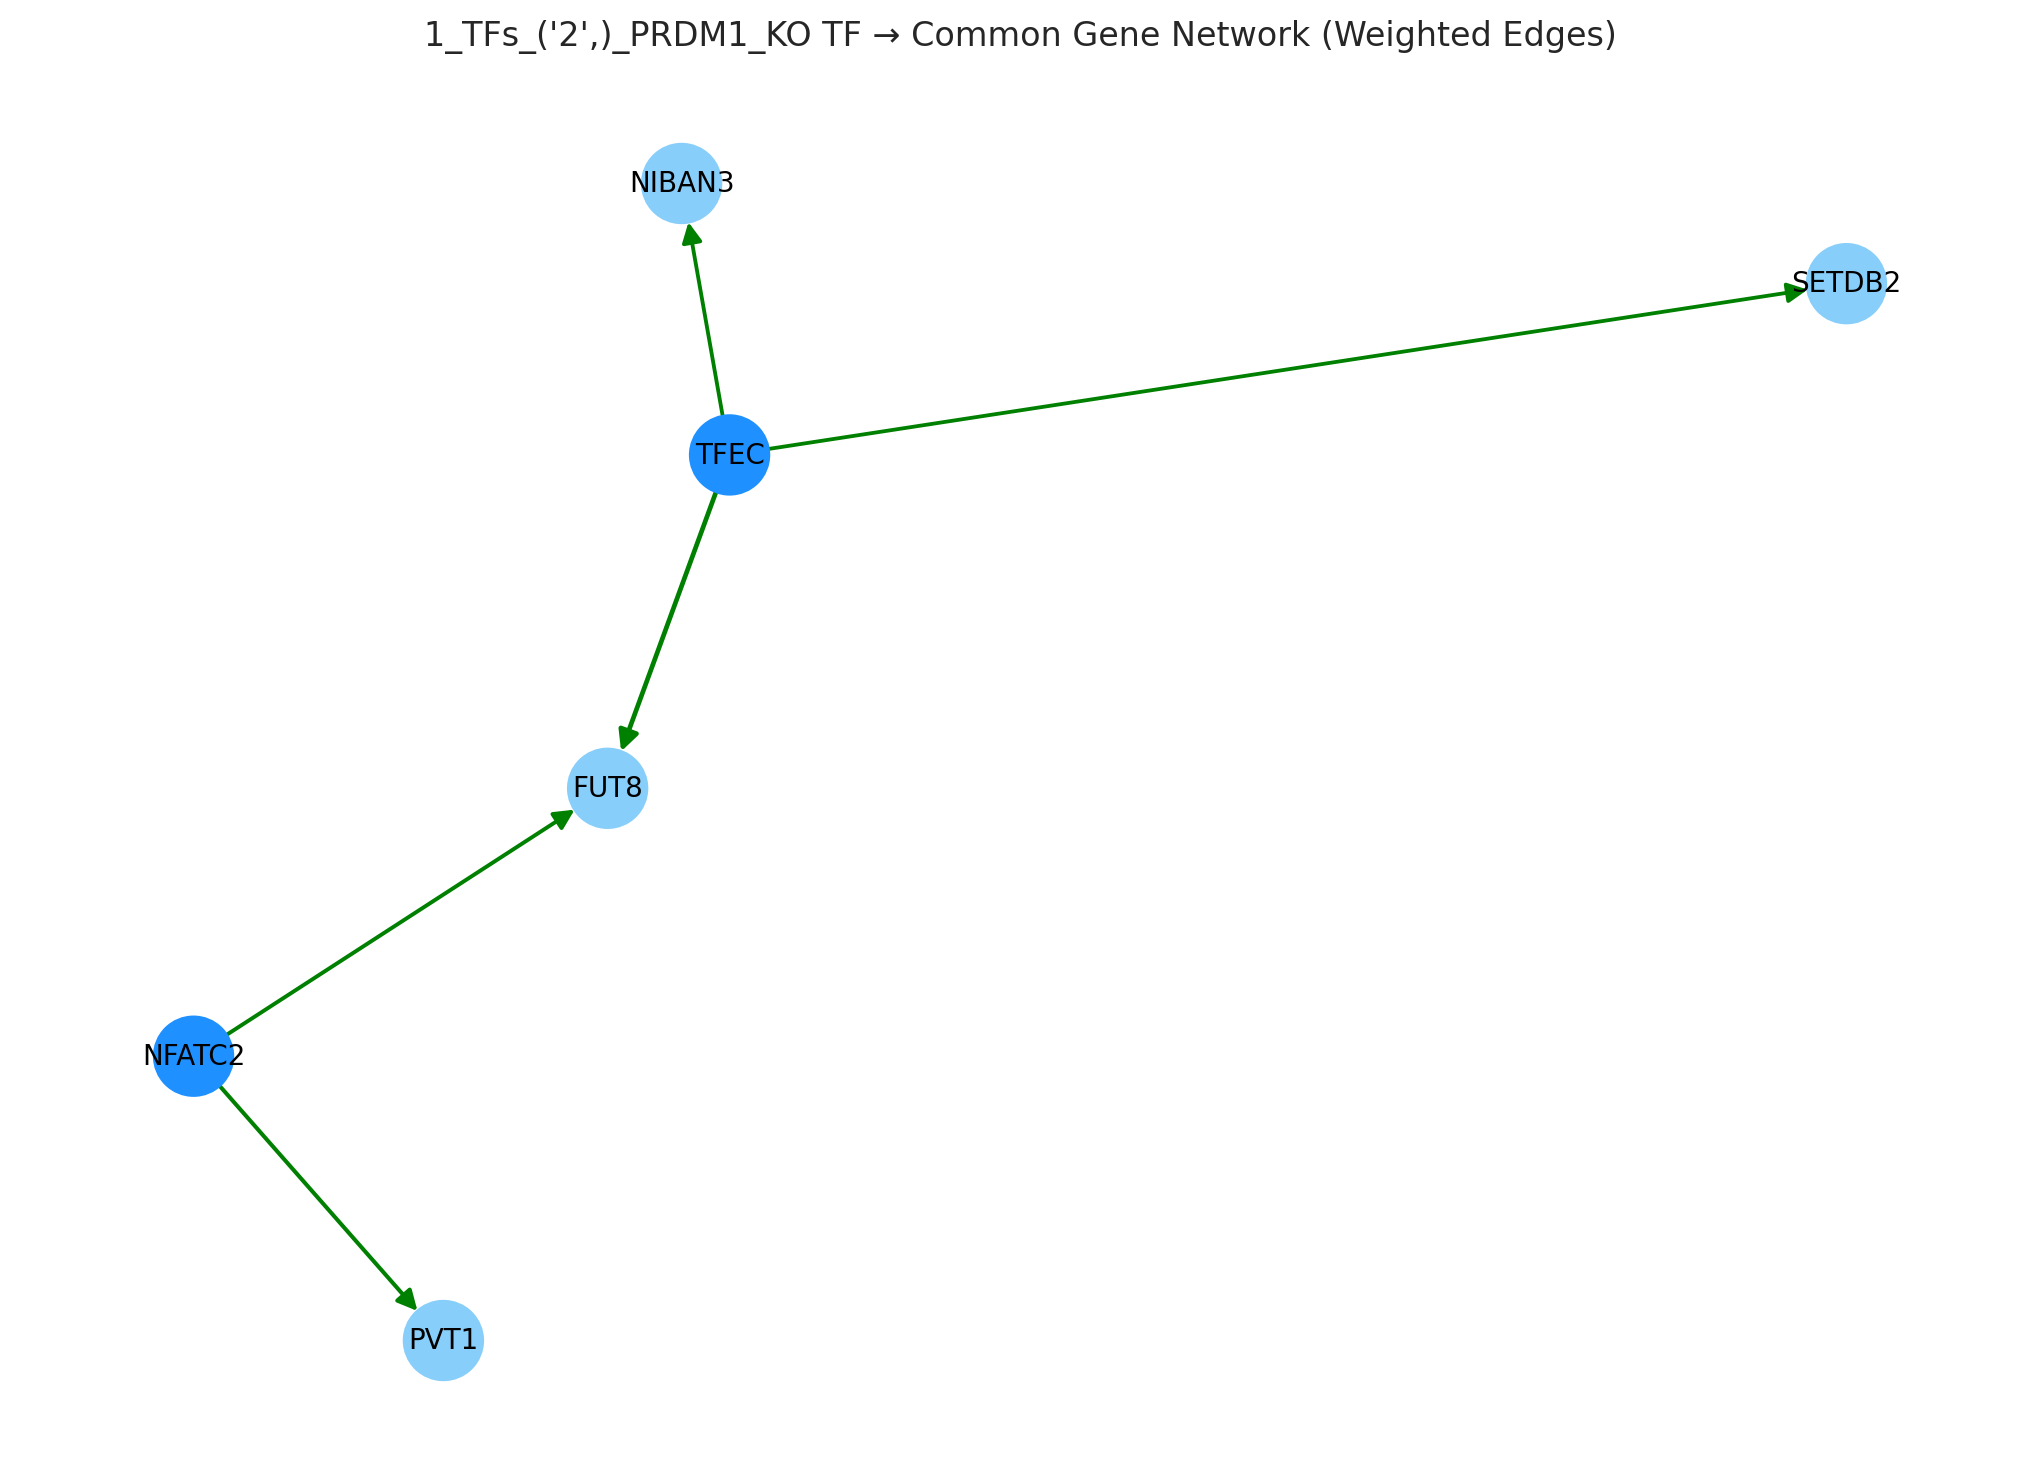

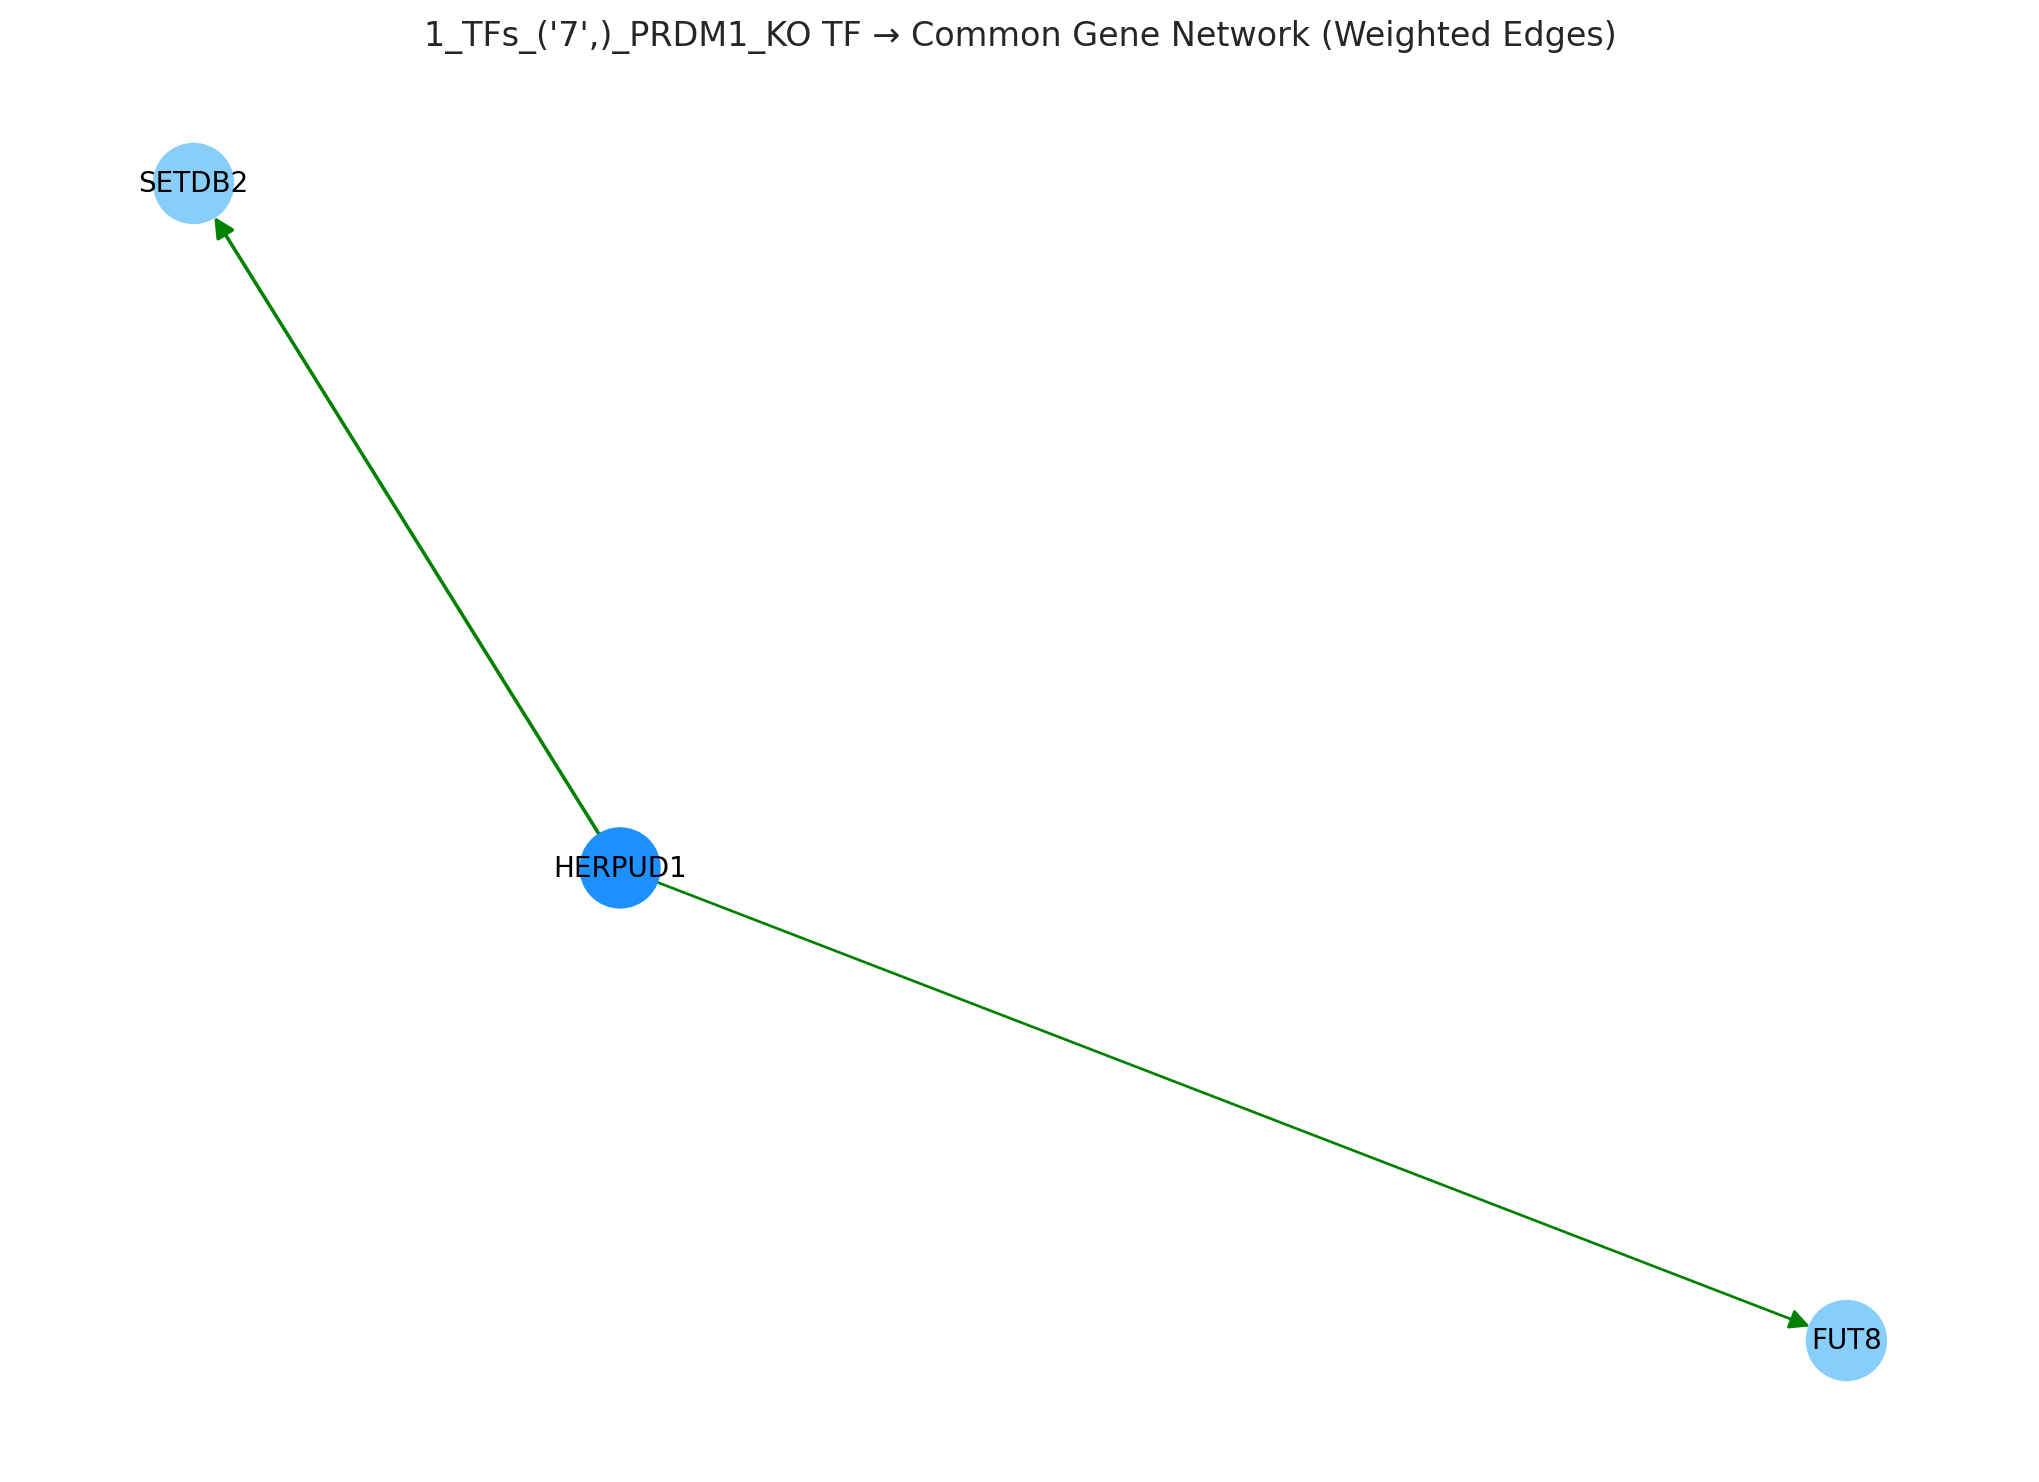

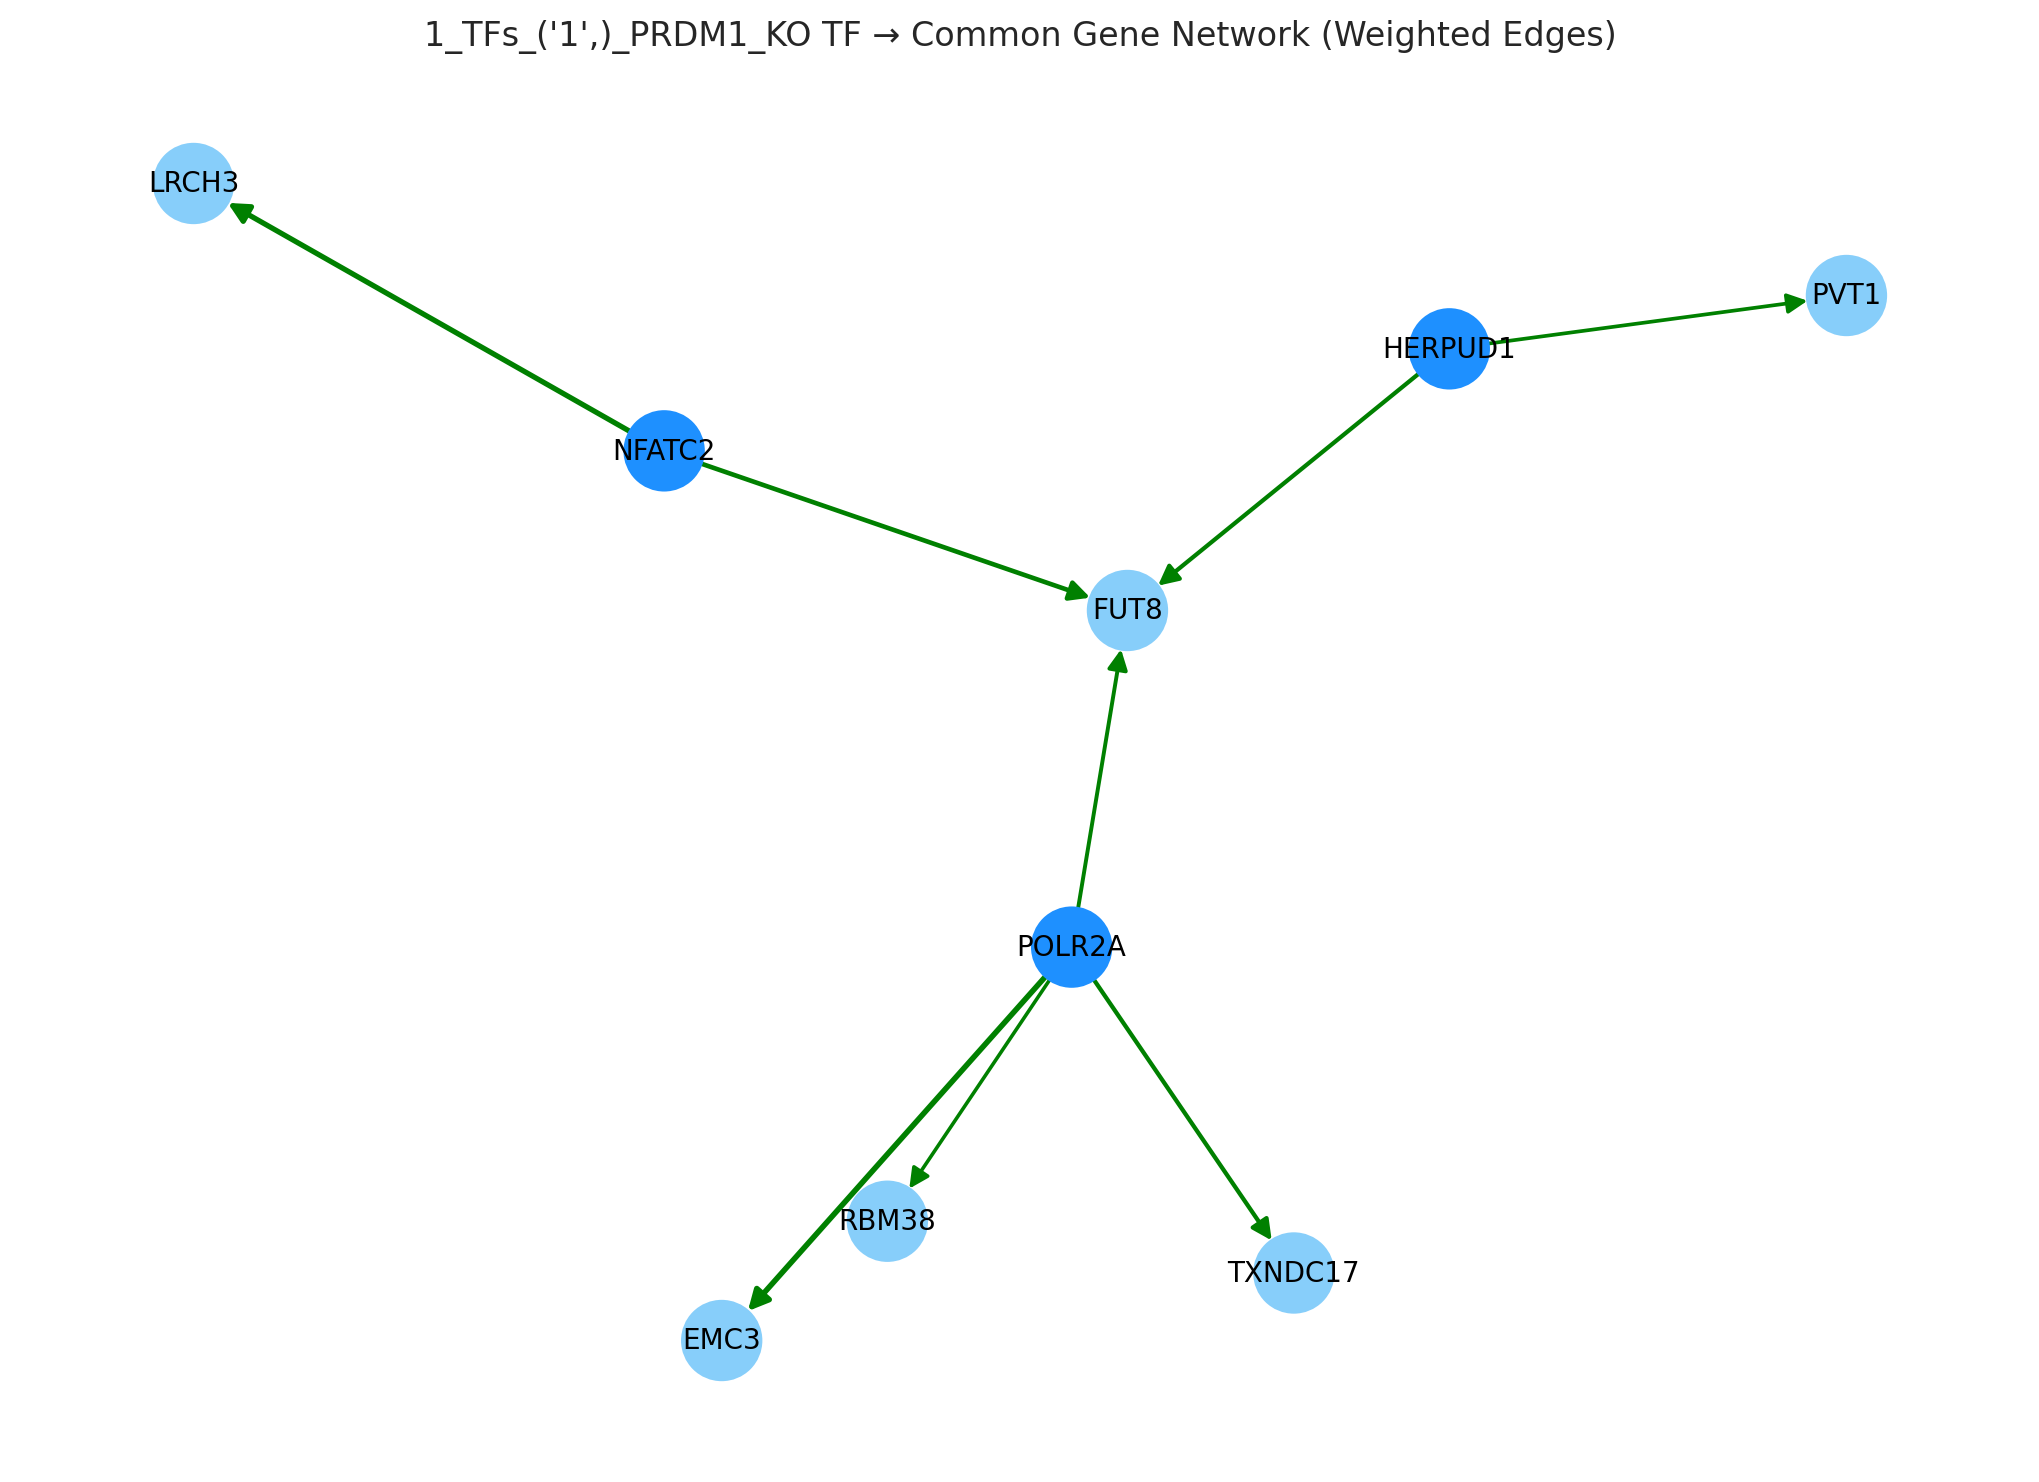

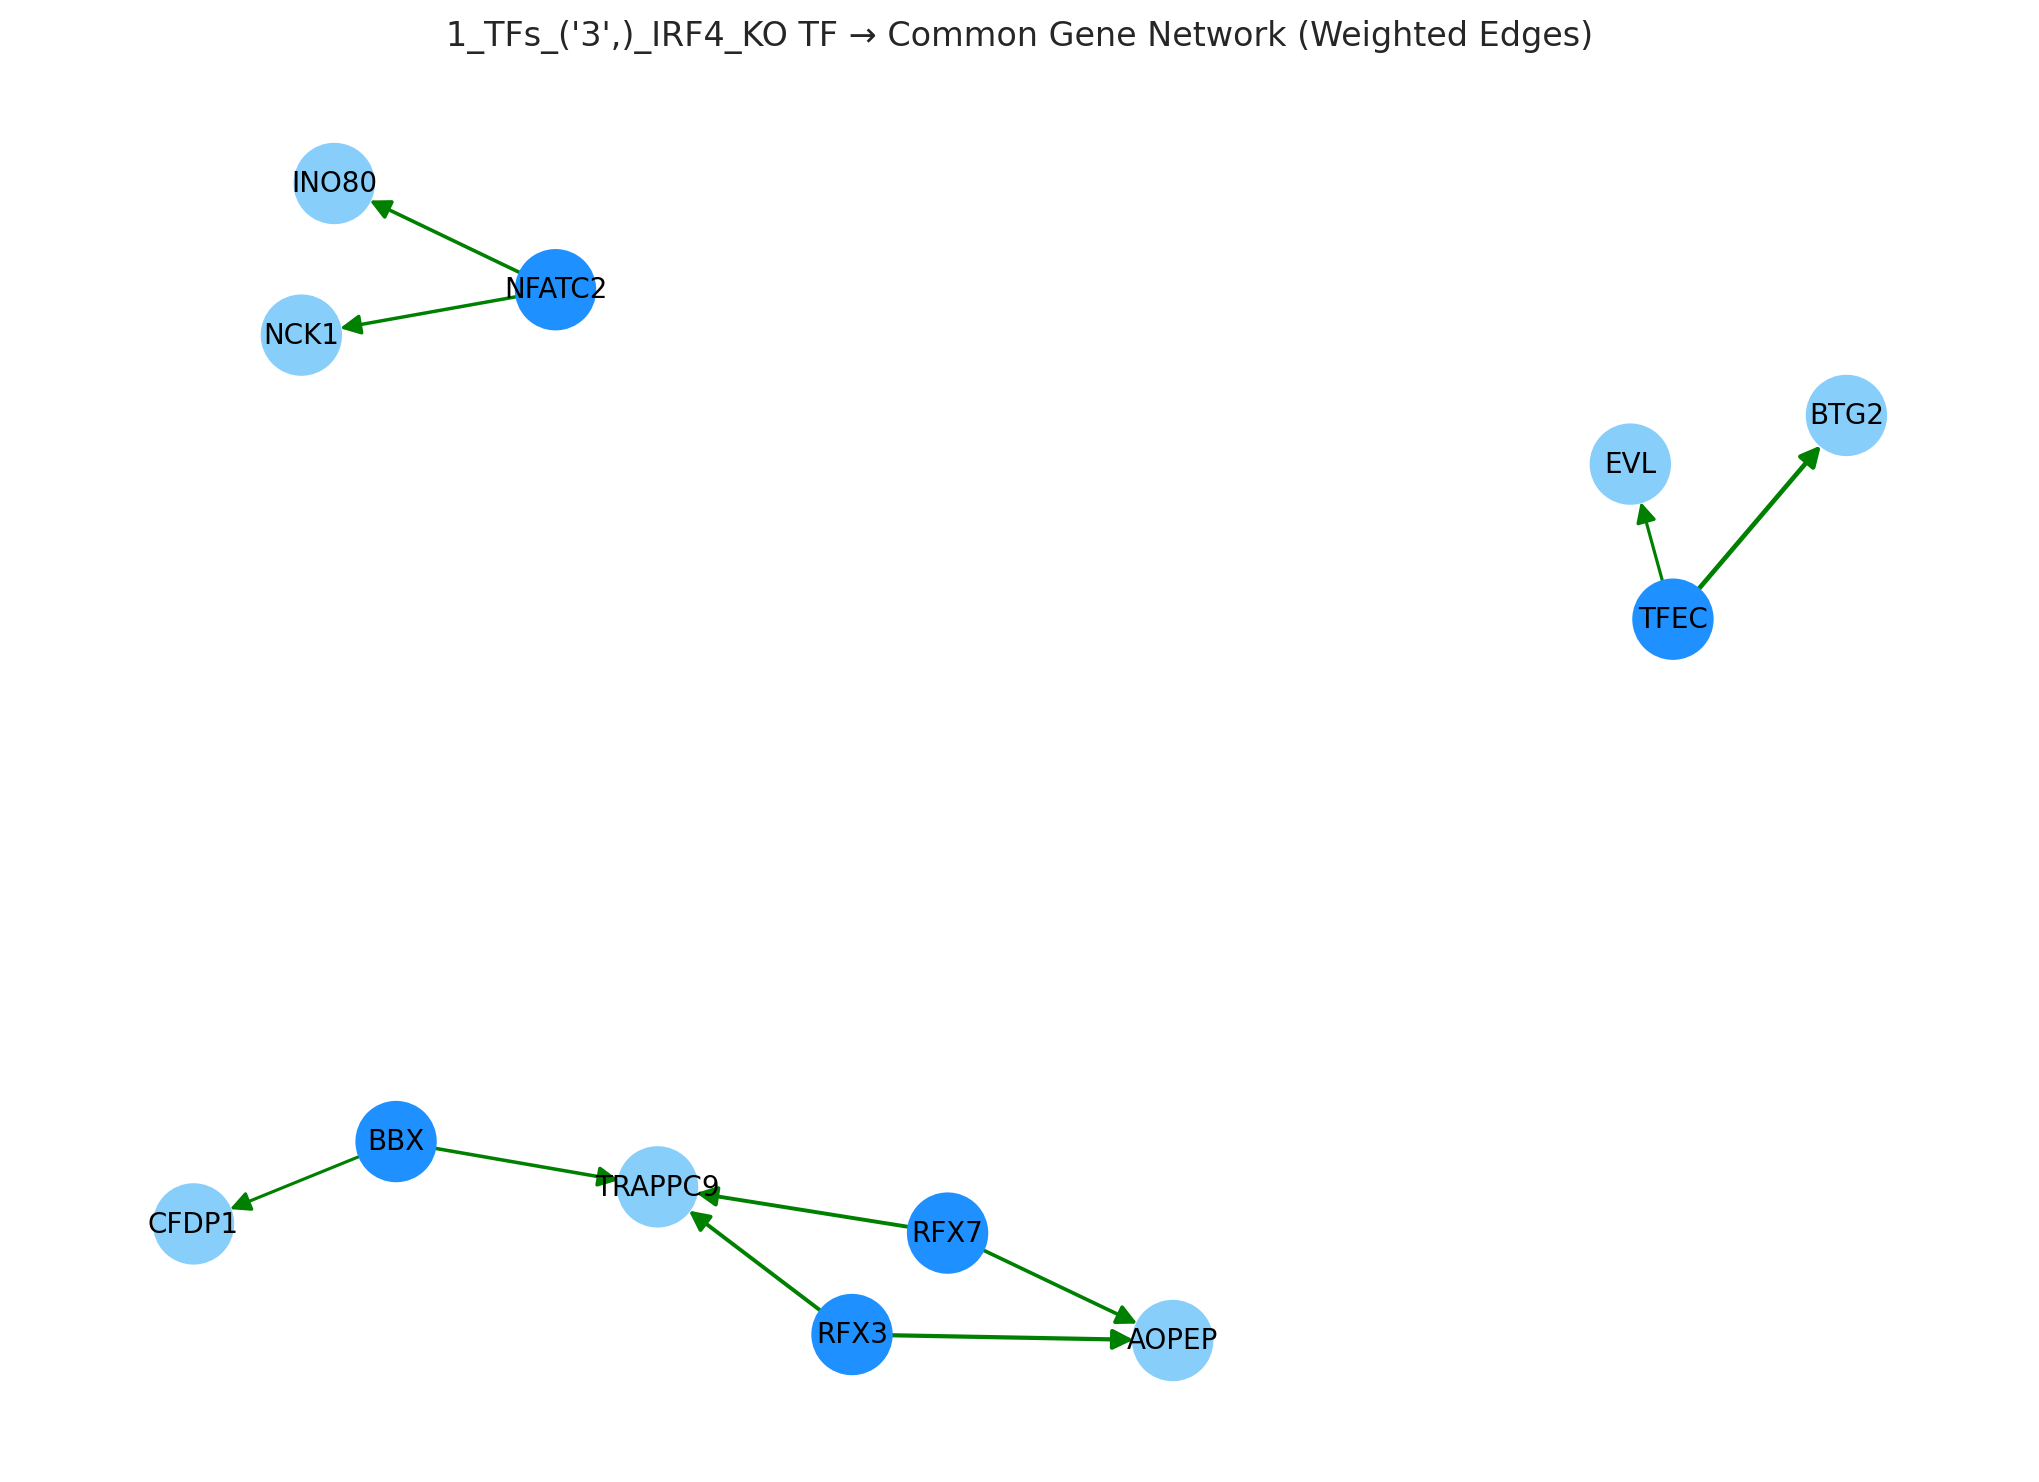

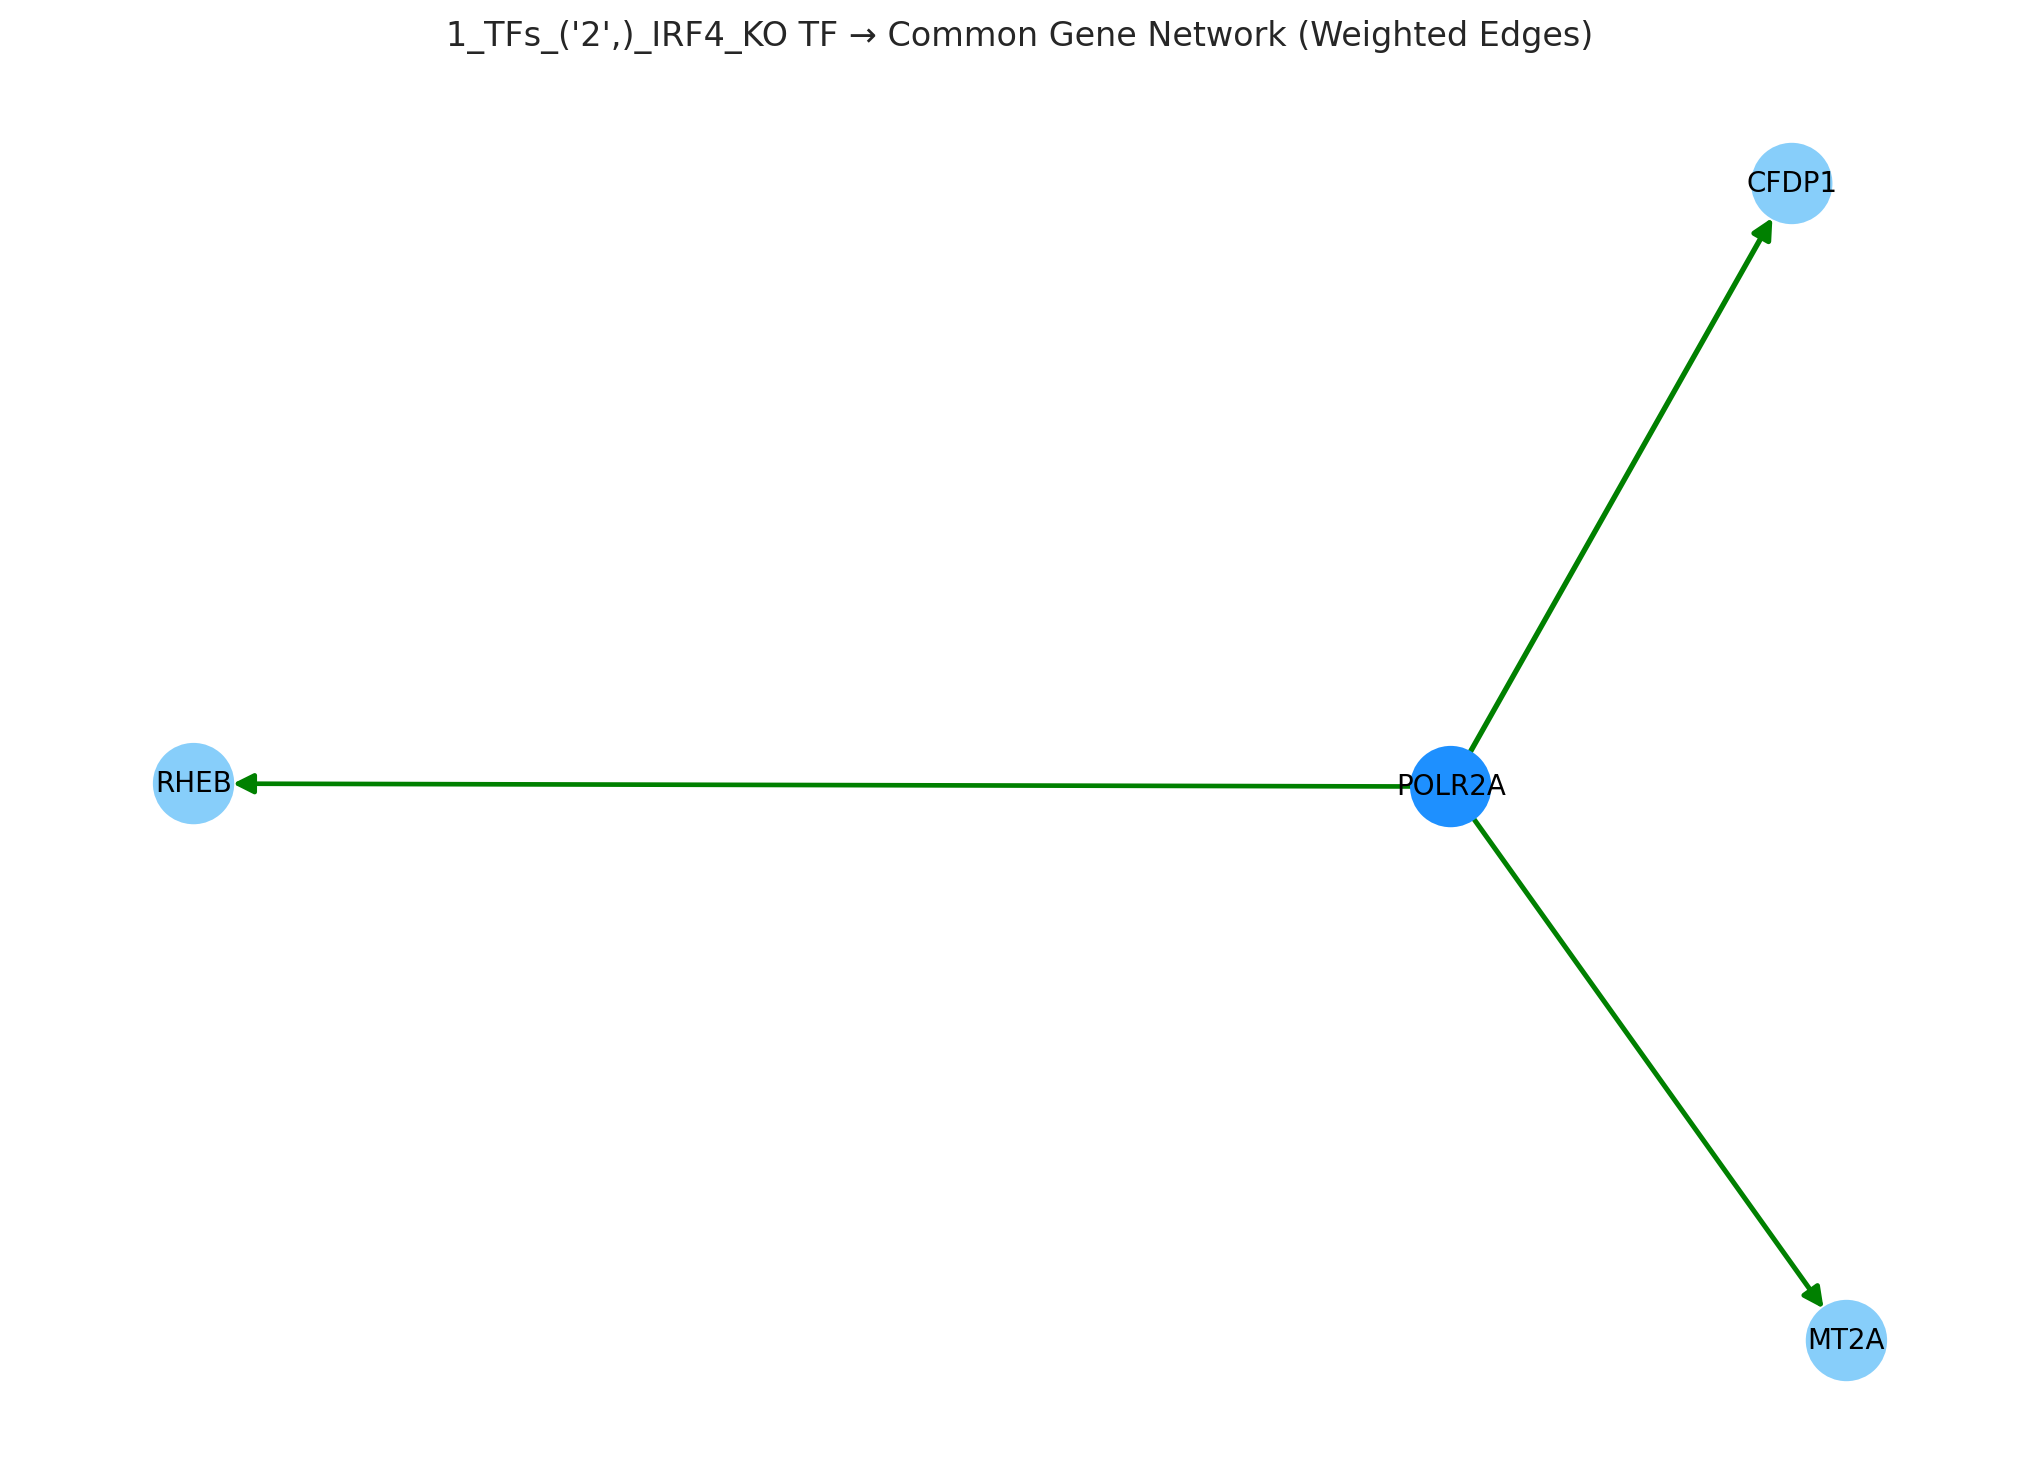

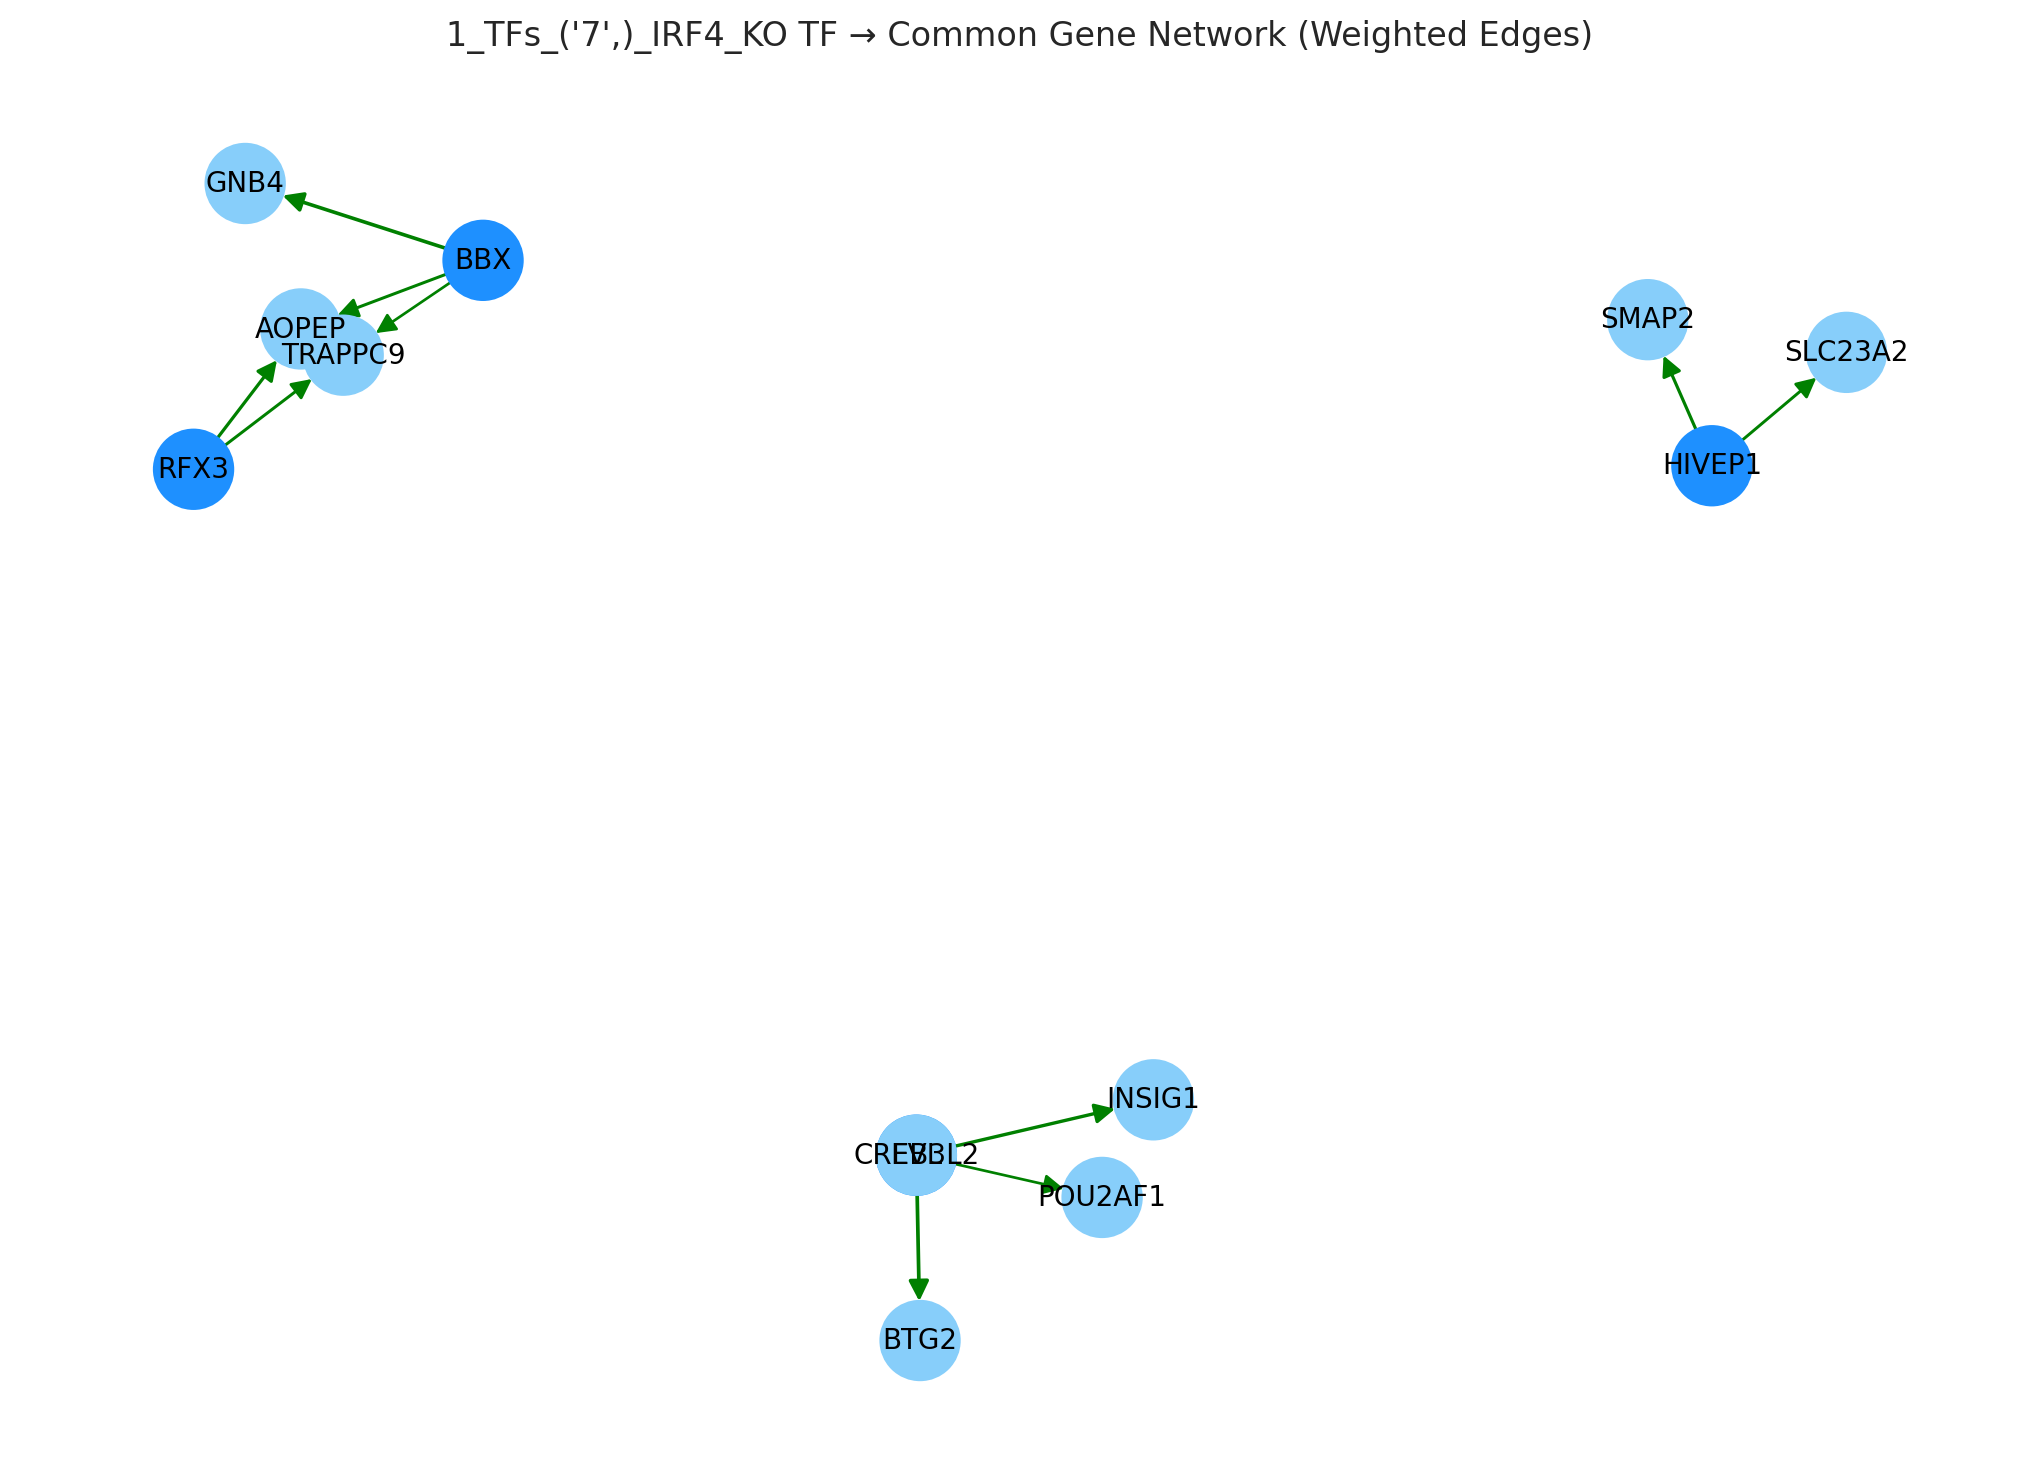

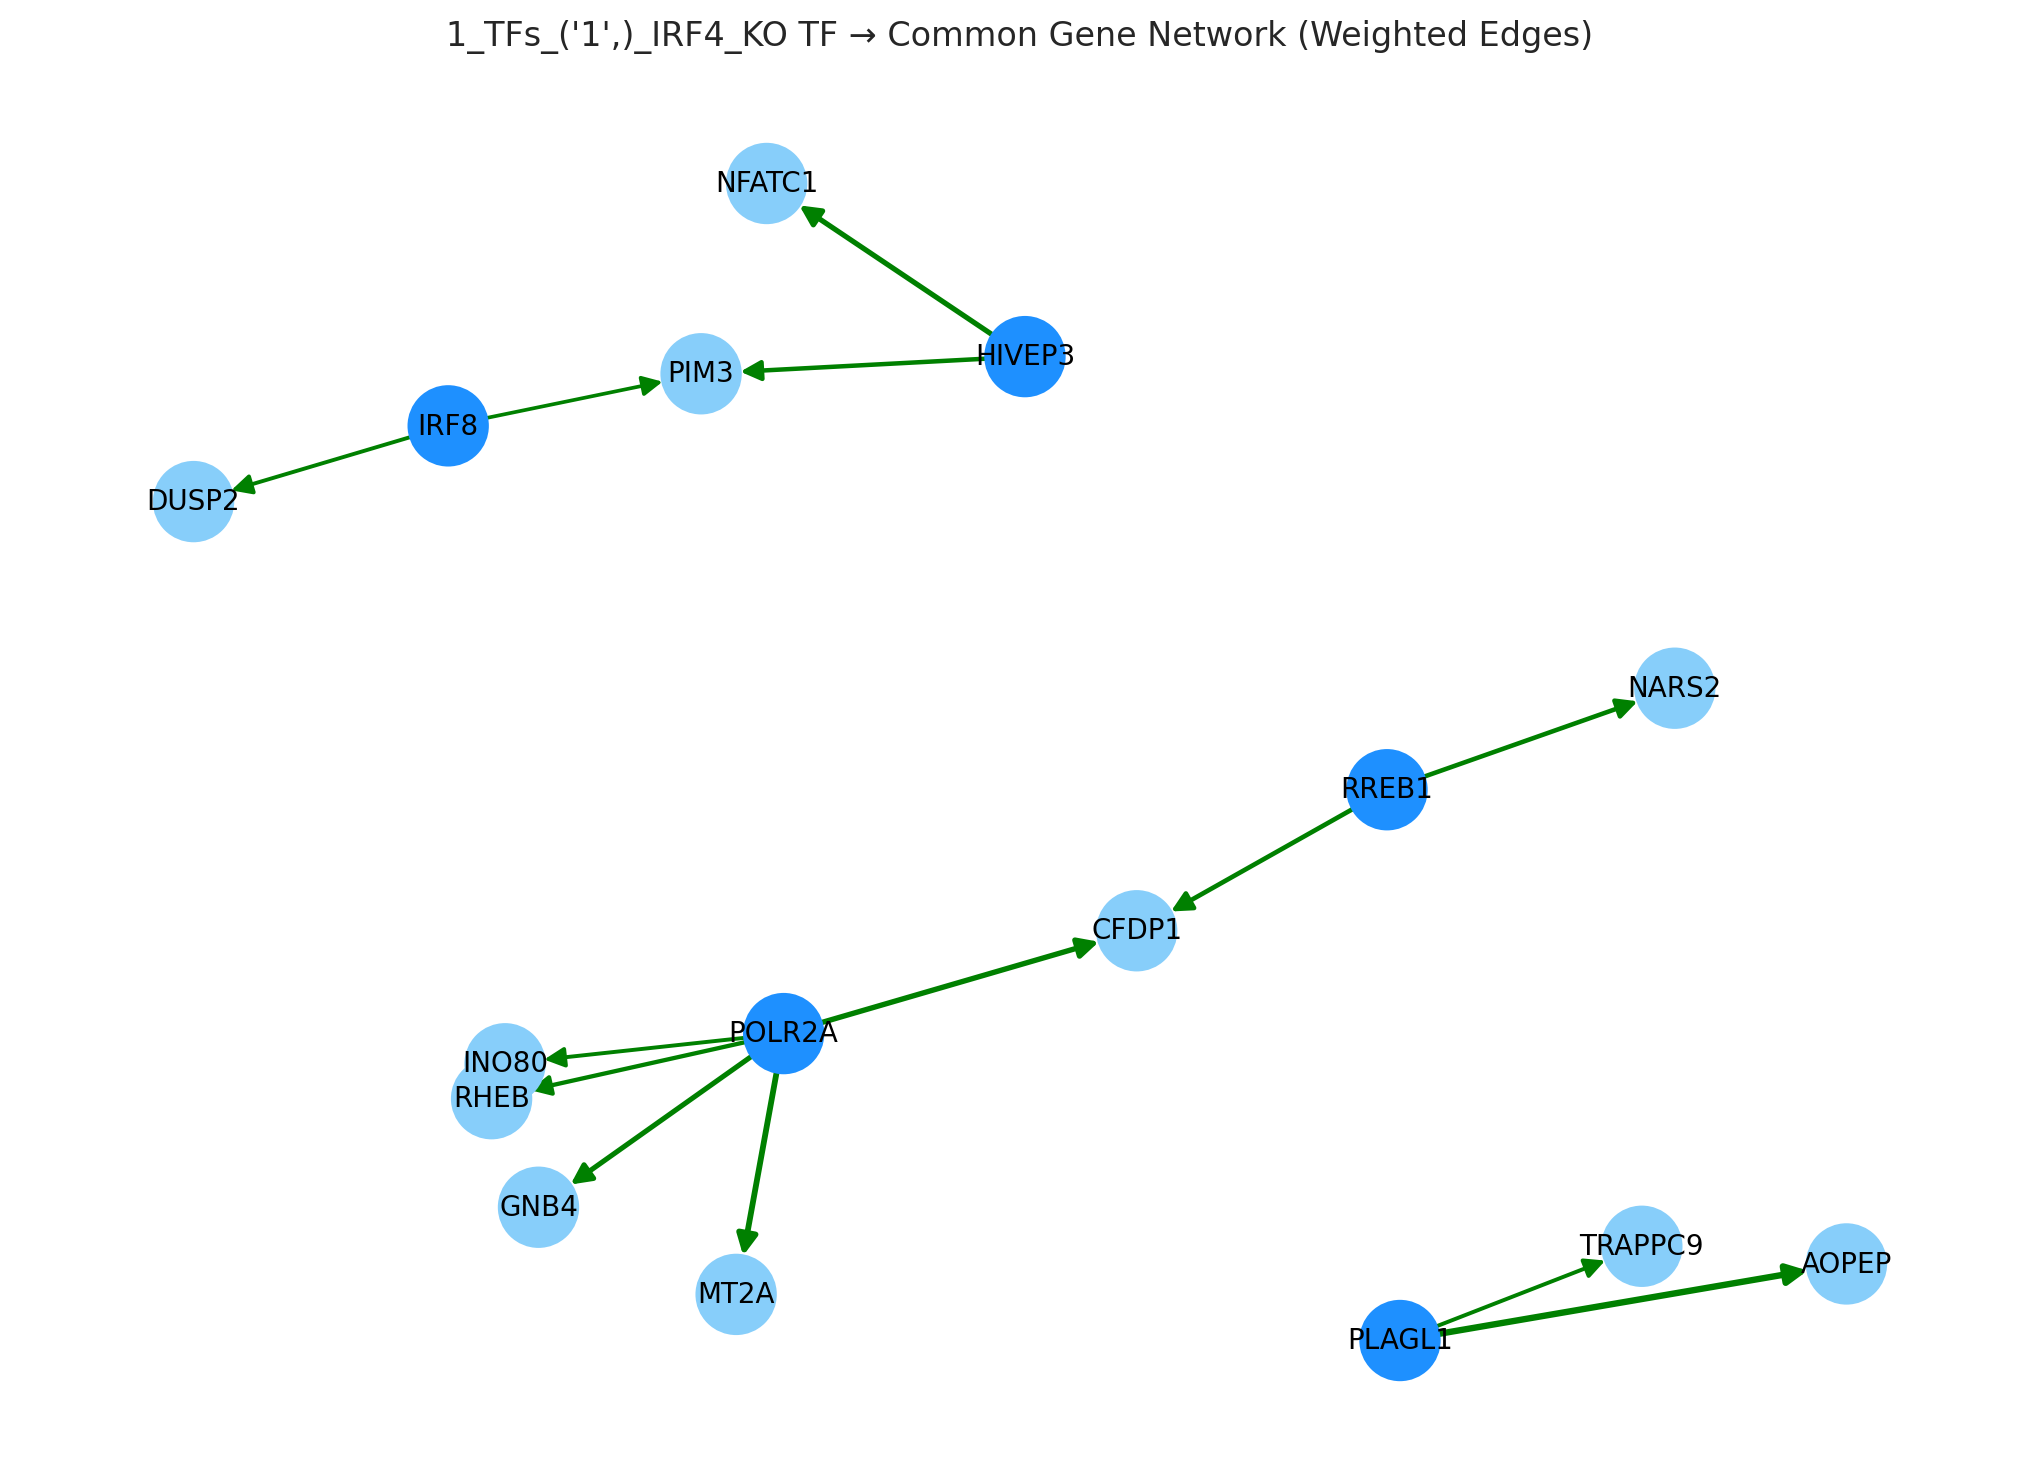

In [30]:
def read_data(M):
    # read SLIDE data
    feature_files = glob.glob(f"{wd}/out_data/out_other_methods/SLIDE_TF_Perturb_Runs/{M}/*/*feature_list*")
    feature_data = [pd.read_csv(file, sep='\t', header = 0) for file in feature_files]
    feature_data = pd.concat(feature_data)
    slide_features = set(feature_data['names'])
    slide_TF = slide_features.intersection(CO_TFs)
    slide_genes = slide_features.difference(CO_TFs)
    return slide_TF, slide_genes

def classify_weights(weights, threshold):
    strong, weak = 0, np.inf
    for weight in weights:
        if abs(weight) > threshold and abs(weight) > abs(strong) :
            strong = weight
        elif abs(weight) < threshold and abs(weight) < abs(weak):
            weak = weight
    return [weak, strong]

def enrichment(M,n,N,X):
    # M is the total number of items in the population ===> Total starting genes in SLIDE
    # n is the number of successes in the population ===> Downstream genes
    # N is the sample size ===> Total SLIDE genes in LF
    # X is the number of successes in the sample.
    p_value = 1 - hypergeom.cdf(X-1, M, n, N)   # Compute the p-value for observing X or more successes
    score = math.log2((X/n)/(N/M))
    return (score, p_value)

def LF_enrichment(cc_dict, cluster_fusion, order_of_combination, suffix=None):
    enrichment_df = pd.DataFrame(cc_dict[cluster_fusion][order_of_combination], columns=['TF', 'Condition', 'ES', 'Genes'])
    enrichment_df[['Score', 'p_value']] = pd.DataFrame(enrichment_df['ES'].tolist(), index=enrichment_df.index)
    enrichment_df[['common', 'cmn_wt_list' , 'dwnstrm', 'dwn_wt_list']] = pd.DataFrame(enrichment_df['Genes'].tolist(), index=enrichment_df.index)
    enrichment_df = enrichment_df.drop(columns=['ES', 'Genes'])
    filter_enrichment_df = (enrichment_df['p_value']<1) \
                            & (enrichment_df['dwnstrm'].apply(len)>1) & (enrichment_df['common'].apply(len)>1) \
                            & (enrichment_df['Score']>0) & (enrichment_df['Condition']==(1,))
    enrichment_df = enrichment_df[filter_enrichment_df].sort_values(by='Score', ascending=False)
    enrichment_df.to_csv(f"{out_path}/out_files/SLIDE_LF_enriched_{order_of_combination}_TFs_{cluster_fusion}{suffix}.csv", index=False)
    return enrichment_df

def plot_graph(enrichment_df, suffix = None):
    G = nx.DiGraph()

    # Add edges with weights
    tfs = []
    for _, row in enrichment_df.iterrows():
        tf = row['TF'][0]
        tfs.append(tf)
        for gene, wt in zip(row['common'], row['cmn_wt_list']):
            G.add_edge(tf, gene, weight=wt[0])

    # Node colors
    node_colors = []
    for node in G.nodes():
        if node in tfs:
            node_colors.append("dodgerblue")  # TFs
        else:
            node_colors.append("lightskyblue")  # Genes

    # Get edge weights
    # weights = [G[u][v]['weight']*5 for u,v in G.edges()]  # scale up for visibility
    edges = G.edges()
    weights = []
    edge_colors = []
    for u, v in edges:
        w = G[u][v]['weight']
        weights.append(abs(w) * 5)  # Thickness scaled, abs to avoid negative widths
        if w >= 0:
            edge_colors.append('green')
        else:
            edge_colors.append('red')

    # Draw the graph
    plt.figure(figsize=(10, 7))
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors,
            width=weights, node_size=800, font_size=10, arrowsize=15)
    plt.title(f"{suffix} TF → Common Gene Network (Weighted Edges)")
    plt.tight_layout()
    plt.savefig(f"{out_path}/figures/SLIDE_LF_enrichment_network{suffix}.pdf")

weight = 'coef_mean'
M_dict = {
    'PRDM1_KO': 4472,
    'IRF4_KO': 4500,
}

master_dict = {}
for M_cond, M in M_dict.items():
    slide_TF, slide_genes = read_data(M_cond)
    cc_dict = {}
    clusters_of_interest = ['3','2','7','1']
    clusters_of_interest_order = [1] # clusters_of_interest_order = [1, 2, ...] # 1 for one cluster, 2 for two clusters
    tf_combination_order = [1] # tf_combination_order = [1, 2, ...] # 1 for one TF, 2 for two TFs
    
    # if clstr_fr_pairwise_comp is None:
    #     clstr_fr_pairwise_comp = list(links_after_fit.keys())
    for order_of_cluster in clusters_of_interest_order:
        cluster_fusions = list(itertools.combinations(clusters_of_interest, order_of_cluster))
        for cluster_fusion in cluster_fusions:
            combined_links = pd.DataFrame()
            for cluster_id in cluster_fusion:
                combined_links = pd.concat([combined_links, links_after_fit[cluster_id]]).sort_values(by=weight, ascending=False)
            combined_links['sorted_source'] = combined_links[['source', 'target']].min(axis=1)
            combined_links['sorted_target'] = combined_links[['source', 'target']].max(axis=1)
            # Classifying the weights
            min_weight_threshold = abs(combined_links[weight]).quantile(0.90)
            print(f"Minimum weight threshold for {cluster_fusion}: {min_weight_threshold}")
            grouped_df = combined_links.groupby(['sorted_source', 'sorted_target'])[weight].apply(lambda x: classify_weights(x, min_weight_threshold)).reset_index()
            
            graph = nx.from_pandas_edgelist(grouped_df, source='sorted_source', target='sorted_target',edge_attr=weight).to_undirected()
            # Integrating SLIDE
            slide_genes_TF = list(combined_links[combined_links['target'].isin(slide_genes)]['source'].unique())
            total_source = set(slide_TF).union(set(slide_genes_TF)).intersection(graph.nodes)
            total_target = set(slide_TF).union(set(slide_genes)).intersection(graph.nodes)
            del combined_links

            for order_of_combination in tf_combination_order:
                possible_TF_combinations = list(itertools.combinations(total_source, order_of_combination))
                cnds_of_int_for_TF_comb = list(itertools.product([0, 1], repeat=order_of_combination))
                cc_dict.setdefault(cluster_fusion, {}).setdefault(order_of_combination, [])
                for TF_comb in possible_TF_combinations:
                    for condition in cnds_of_int_for_TF_comb:
                        common, dwngene = 0, 0
                        cmn_list, cmn_wt_list, dwn_list, dwn_wt_list = [], [], [], []
                        common_targets_from_grn = reduce(set.intersection, map(lambda TF: set(graph[TF].keys()), TF_comb))
                        for target in common_targets_from_grn:
                            # 0 is for weak, 1 is for strong since the weights are classified as [weak, strong]
                            # all(): Ensures that all the conditions hold true for every TF-cond pair.
                            if all(abs(graph[TF][target].get(weight, None)[cond]) > 0 for TF, cond in zip(TF_comb, condition)): # counts for classified weights should be greater than 0
                                dwngene+=1; dwn_list.append(target)
                                dwn_wt_list.append([graph[TF][target].get(weight, None)[cond] for TF, cond in zip(TF_comb, condition)])
                                if target in total_target: 
                                    common+=1; cmn_list.append(target) # enriched in SLIDE LF, increase common
                                    cmn_wt_list.append([graph[TF][target].get(weight, None)[cond] for TF, cond in zip(TF_comb, condition)]) # add the weights of the common targets
                        
                        
                        if dwngene==0 or common==0:
                            cc_dict[cluster_fusion][order_of_combination].append([TF_comb, (condition), (0,1), (cmn_list, cmn_wt_list, dwn_list, dwn_wt_list)])
                        else:
                            cc_dict[cluster_fusion][order_of_combination].append([TF_comb, (condition), enrichment(M,dwngene,len(total_target),common), (cmn_list, cmn_wt_list, dwn_list, dwn_wt_list)])
                enrichment_df = LF_enrichment(cc_dict, cluster_fusion, order_of_combination, f"_{M_cond}")
                plot_graph(enrichment_df, f"{order_of_combination}_TFs_{cluster_fusion}_{M_cond}")
    master_dict[M_cond] = cc_dict


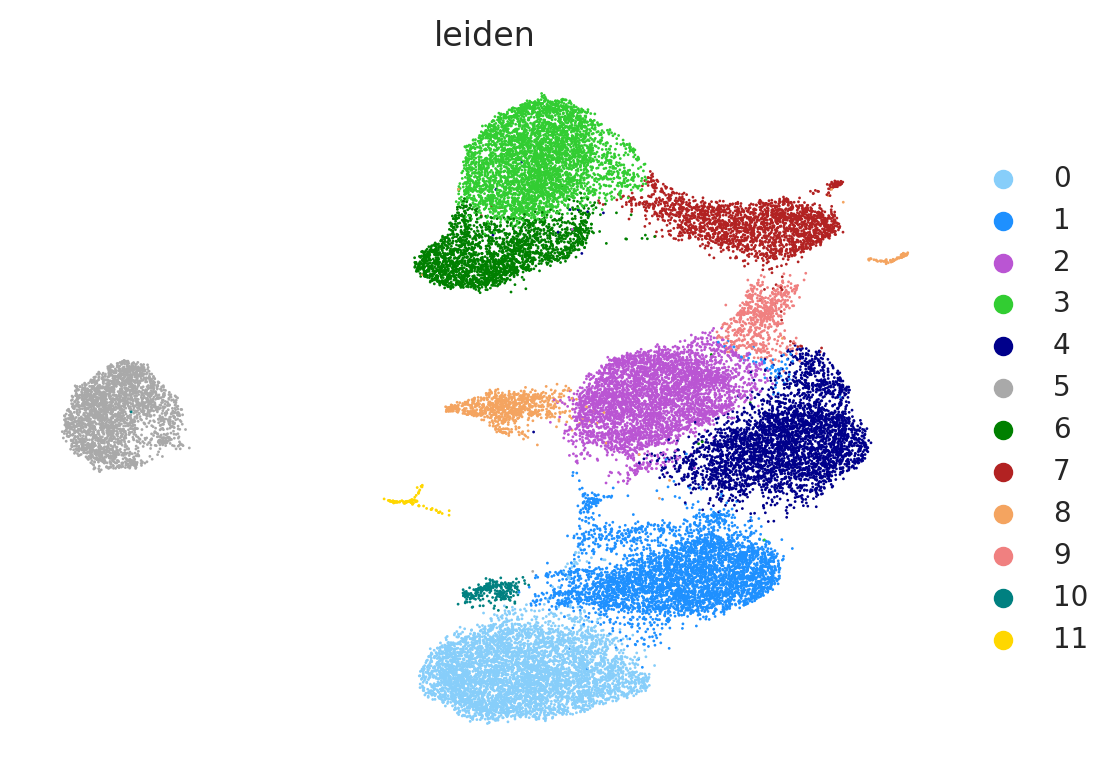

In [4]:
sc.pl.umap(oracle.adata, color=['leiden'], frameon=False)

In [5]:
def classify_weights(weights, threshold):
    strong, weak = 0, np.inf
    for weight in weights:
        if abs(weight) > threshold and abs(weight) > abs(strong) :
            strong = weight
        elif abs(weight) < threshold and abs(weight) < abs(weak):
            weak = weight
    return [weak, strong]

def enrichment(M,n,N,X):
    # M is the total number of items in the population ===> Total starting genes in SLIDE
    # n is the number of successes in the population ===> Downstream genes
    # N is the sample size ===> Total SLIDE genes in LF
    # X is the number of successes in the sample.
    p_value = 1 - hypergeom.cdf(X-1, M, n, N)   # Compute the p-value for observing X or more successes
    score = math.log2((X/n)/(N/M))
    return (score, p_value)

# def LF_enrichment(cc_dict, cluster_pair, comb_tfs, graph, total_source, total_target):
#     cc_dict.setdefault(cluster_pair, {}).setdefault(comb_tfs, {})
#     conditions_of_interest = list(itertools.product([0, 1], repeat=comb_tfs))
#     possible_TF_combinations = list(itertools.combinations(total_source, comb_tfs))
#     print(f"TF_permut: {possible_TF_combinations}")
#     for TF_comb in possible_TF_combinations:
#         for condition in conditions_of_interest:
#             common, dwngene = 0, 0
#             cmn_list, dwn_list = [], []
#             common_targets_from_grn = reduce(set.intersection, map(lambda TF: set(graph[TF].keys()), TF_comb))
#             for target in common_targets_from_grn:
#                 # 0 is for weak, 1 is for strong since the weights are classified as [weak, strong]
#                 # all(): Ensures that all the conditions hold true for every TF-cond pair.
#                 for i in zip(TF_comb, condition):
#                     print(i)
#             #     if all(graph[TF][target].get(weight, None)[cond] > 0 for TF, cond in zip(TF_comb, condition)): # counts for classified weights should be greater than 0
#             #         dwngene+=1; dwn_list.append(target)
#             #         if target in total_target: 
#             #             common+=1; cmn_list.append(target) # enriched in SLIDE LF, increase common
            
#             # if dwngene==0 or common==0:
#             #     cc_dict[cluster_pair][comb_tfs].append([TF_comb, (condition), (0,1), (cmn_list, dwn_list)])
#             # else:
#             #     cc_dict[cluster_pair][comb_tfs].append([TF_comb, (condition), enrichment(M,dwngene,len(total_target),common), (cmn_list, dwn_list)])
#     return cc_dict

def LF_enrichment(cc_dict, cluster_fusion, order_of_combination, suffix=None):
    enrichment_df = pd.DataFrame(cc_dict[cluster_fusion][order_of_combination], columns=['TF', 'Condition', 'ES', 'Genes'])
    enrichment_df[['Score', 'p_value']] = pd.DataFrame(enrichment_df['ES'].tolist(), index=enrichment_df.index)
    enrichment_df[['common', 'cmn_wt_list' , 'dwnstrm', 'dwn_wt_list']] = pd.DataFrame(enrichment_df['Genes'].tolist(), index=enrichment_df.index)
    enrichment_df = enrichment_df.drop(columns=['ES', 'Genes'])
    filter_enrichment_df = (enrichment_df['p_value']<1) \
                            & (enrichment_df['dwnstrm'].apply(len)>1) & (enrichment_df['common'].apply(len)>1) \
                            & (enrichment_df['Score']>0) & (enrichment_df['Condition']==(1,))
    enrichment_df = enrichment_df[filter_enrichment_df].sort_values(by='Score', ascending=False)
    enrichment_df.to_csv(f"{out_path}/out_files/SLIDE_LF_enriched_{order_of_combination}_TFs_{cluster_fusion}{suffix}.csv", index=False)
    return enrichment_df

In [14]:
# min_weight_threshold = 0.2
weight = 'coef_mean'

M_dict = {
    'PRDM1-KO': 4472,
    'IRF4-KO': 4500,
    'GC-PB': 4725,
    'PB-ABC': 3420,
    'GC-ABC': 4603,
}

master_dict = {}
for M_cond, M in M_dict.items():
    cc_dict = {}
    clusters_of_interest = ['3','2','7','1']
    clusters_of_interest_order = [1] # clusters_of_interest_order = [1, 2, ...] # 1 for one cluster, 2 for two clusters
    tf_combination_order = [1] # tf_combination_order = [1, 2, ...] # 1 for one TF, 2 for two TFs
    
    # if clstr_fr_pairwise_comp is None:
    #     clstr_fr_pairwise_comp = list(links_after_fit.keys())
    for order_of_cluster in clusters_of_interest_order:
        cluster_fusions = list(itertools.combinations(clusters_of_interest, order_of_cluster))
        for cluster_fusion in cluster_fusions:
            combined_links = pd.DataFrame()
            for cluster_id in cluster_fusion:
                combined_links = pd.concat([combined_links, links_after_fit[cluster_id]]).sort_values(by=weight, ascending=False)
            combined_links['sorted_source'] = combined_links[['source', 'target']].min(axis=1)
            combined_links['sorted_target'] = combined_links[['source', 'target']].max(axis=1)
            # Classifying the weights
            min_weight_threshold = abs(combined_links[weight]).quantile(0.90)
            print(f"Minimum weight threshold for {cluster_fusion}: {min_weight_threshold}")
            grouped_df = combined_links.groupby(['sorted_source', 'sorted_target'])[weight].apply(lambda x: classify_weights(x, min_weight_threshold)).reset_index()
            
            graph = nx.from_pandas_edgelist(grouped_df, source='sorted_source', target='sorted_target',edge_attr=weight).to_undirected()
            # Integrating SLIDE
            slide_genes_TF = list(combined_links[combined_links['target'].isin(slide_genes)]['source'].unique())
            total_source = set(slide_TF).union(set(slide_genes_TF)).intersection(graph.nodes)
            total_target = set(slide_TF).union(set(slide_genes)).intersection(graph.nodes)
            del combined_links

            for order_of_combination in tf_combination_order:
                possible_TF_combinations = list(itertools.combinations(total_source, order_of_combination))
                cnds_of_int_for_TF_comb = list(itertools.product([0, 1], repeat=order_of_combination))
                cc_dict.setdefault(cluster_fusion, {}).setdefault(order_of_combination, [])
                for TF_comb in possible_TF_combinations:
                    for condition in cnds_of_int_for_TF_comb:
                        common, dwngene = 0, 0
                        cmn_list, cmn_wt_list, dwn_list, dwn_wt_list = [], [], [], []
                        common_targets_from_grn = reduce(set.intersection, map(lambda TF: set(graph[TF].keys()), TF_comb))
                        for target in common_targets_from_grn:
                            # 0 is for weak, 1 is for strong since the weights are classified as [weak, strong]
                            # all(): Ensures that all the conditions hold true for every TF-cond pair.
                            if all(abs(graph[TF][target].get(weight, None)[cond]) > 0 for TF, cond in zip(TF_comb, condition)): # counts for classified weights should be greater than 0
                                dwngene+=1; dwn_list.append(target)
                                dwn_wt_list.append([graph[TF][target].get(weight, None)[cond] for TF, cond in zip(TF_comb, condition)])
                                if target in total_target: 
                                    common+=1; cmn_list.append(target) # enriched in SLIDE LF, increase common
                                    cmn_wt_list.append([graph[TF][target].get(weight, None)[cond] for TF, cond in zip(TF_comb, condition)]) # add the weights of the common targets
                        
                        
                        if dwngene==0 or common==0:
                            cc_dict[cluster_fusion][order_of_combination].append([TF_comb, (condition), (0,1), (cmn_list, cmn_wt_list, dwn_list, dwn_wt_list)])
                        else:
                            cc_dict[cluster_fusion][order_of_combination].append([TF_comb, (condition), enrichment(M,dwngene,len(total_target),common), (cmn_list, cmn_wt_list, dwn_list, dwn_wt_list)])
                LF_enrichment(cc_dict, cluster_fusion, order_of_combination, f"_{M_cond}")
    master_dict[M_cond] = cc_dict
    # Write the results to a file

        # cc_dict = LF_enrichment(cc_dict, i, comparision, graph, total_source, total_target)




Minimum weight threshold for ('3',): 0.2226148122173493
Minimum weight threshold for ('2',): 0.2385623474755033
Minimum weight threshold for ('7',): 0.191980054722947
Minimum weight threshold for ('1',): 0.2513525637427023
Minimum weight threshold for ('3',): 0.2226148122173493
Minimum weight threshold for ('2',): 0.2385623474755033
Minimum weight threshold for ('7',): 0.191980054722947
Minimum weight threshold for ('1',): 0.2513525637427023


In [7]:
cluster_fusions

[('3',), ('2',), ('7',), ('1',)]

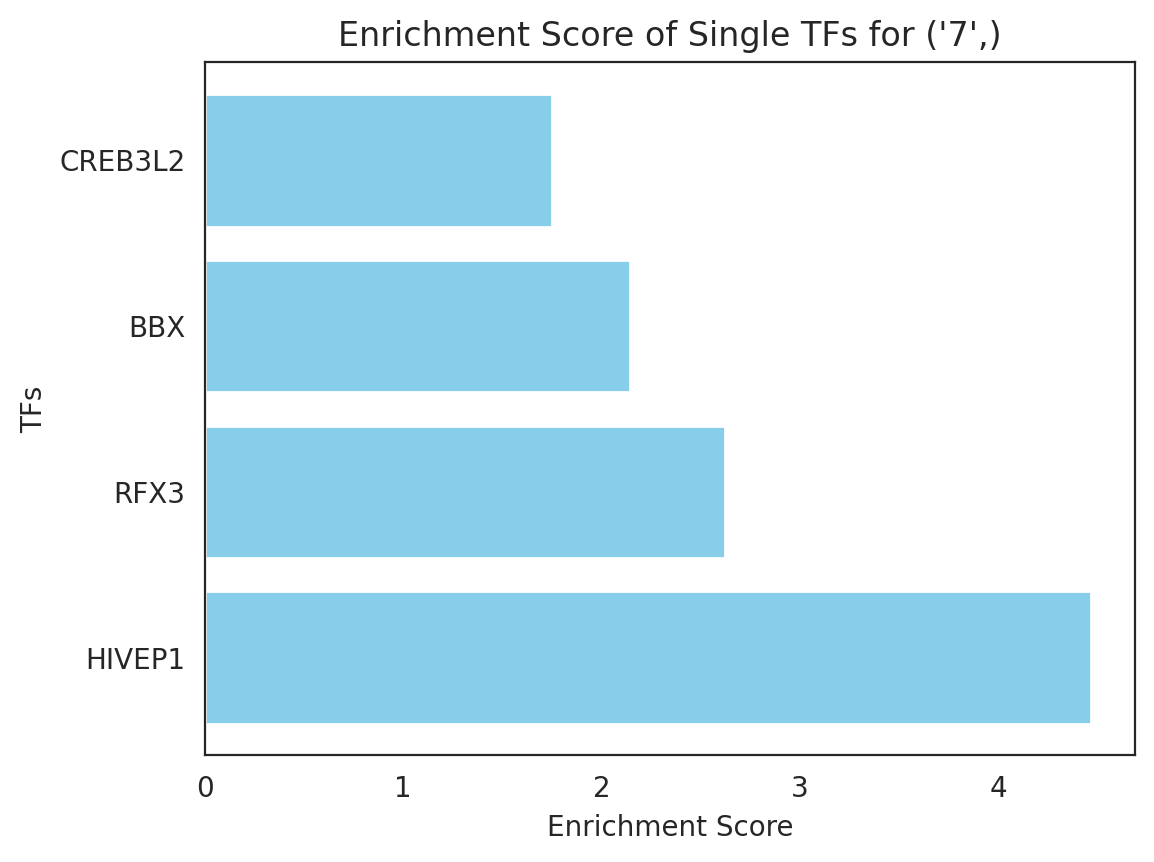

In [123]:
def LF_enrichment(cluster_fusion, order_of_combination):
    enrichment_df = pd.DataFrame(cc_dict[cluster_fusion][order_of_combination], columns=['TF', 'Condition', 'ES', 'Genes'])
    enrichment_df[['Score', 'p_value']] = pd.DataFrame(enrichment_df['ES'].tolist(), index=enrichment_df.index)
    enrichment_df[['common', 'cmn_wt_list' , 'dwnstrm', 'dwn_wt_list']] = pd.DataFrame(enrichment_df['Genes'].tolist(), index=enrichment_df.index)
    enrichment_df = enrichment_df.drop(columns=['ES', 'Genes'])
    filter_enrichment_df = (enrichment_df['p_value']<1) \
                            & (enrichment_df['dwnstrm'].apply(len)>1) & (enrichment_df['common'].apply(len)>1) \
                            & (enrichment_df['Score']>0) & (enrichment_df['Condition']==(1,))
    enrichment_df = enrichment_df[filter_enrichment_df].sort_values(by='Score', ascending=False)
    enrichment_df.to_csv(f"{out_path}/out_files/SLIDE_LF_enriched_{order_of_combination}_TFs_{cluster_fusion}.csv", index=False)
    plt.barh(enrichment_df['TF'].apply(lambda x: x[0]), enrichment_df['Score'], color='skyblue')
    plt.xlabel('Enrichment Score')
    plt.ylabel('TFs')
    plt.title(f'Enrichment Score of Single TFs for {cluster_fusion}')
    # plt.savefig(f"{out_path}/figures/SLIDE_LF_enriched_single_TFs_{cluster_pair}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

In [51]:
def find_single_TF_enrichment(cluster_pair):
    enrichment_df = pd.DataFrame(cc_dict[cluster_pair][1], columns=['TF', 'Condition', 'ES', 'Genes'])
    enrichment_df[['Score', 'p_value']] = pd.DataFrame(enrichment_df['ES'].tolist(), index=enrichment_df.index)
    enrichment_df[['common', 'dwnstrm']] = pd.DataFrame(enrichment_df['Genes'].tolist(), index=enrichment_df.index)
    enrichment_df = enrichment_df.drop(columns=['ES', 'Genes'])
    filter_enrichment_df = (enrichment_df['p_value']<1) \
                            & (enrichment_df['dwnstrm'].apply(len)>1) & (enrichment_df['common'].apply(len)>1) \
                            & (enrichment_df['Score']>0) & (enrichment_df['Condition']==(1,))
    enrichment_df = enrichment_df[filter_enrichment_df].sort_values(by='Score', ascending=False)
    enrichment_df.to_csv(f"{out_path}/out_files/SLIDE_LF_enriched_single_TFs_{cluster_pair}.csv", index=False)

    plt.figure(figsize=(10, 6))
    plt.barh(enrichment_df['TF'].apply(lambda x: x[0]), enrichment_df['Score'], color='skyblue')
    plt.xlabel('Enrichment Score')
    plt.ylabel('TFs')
    plt.title(f'Enrichment Score of Single TFs for {cluster_pair}')
    plt.savefig(f"{out_path}/figures/SLIDE_LF_enriched_single_TFs_{cluster_pair}.pdf", dpi=300, bbox_inches='tight')
    plt.close()

In [52]:
find_single_TF_enrichment(('3',))

KeyError: ('3',)

In [22]:
combined_links

,source,target,coef_mean,coef_abs,sorted_source,sorted_target
8826,ZBTB7A,JMJD1C,0.634570,0.634570,JMJD1C,ZBTB7A
8100,POLR2A,EZR,0.629933,0.629933,EZR,POLR2A
8175,POLR2A,MKI67,0.539864,0.539864,MKI67,POLR2A
7418,CREBBP,ATAD2B,0.513672,0.513672,ATAD2B,CREBBP
7408,MEF2A,ZNF407,0.488085,0.488085,MEF2A,ZNF407
...,...,...,...,...,...,...
4378,PLAG1,SLC5A3,-0.000057,0.000057,PLAG1,SLC5A3
4417,BHLHE22,TGFBR2,-0.000045,0.000045,BHLHE22,TGFBR2
9290,FOSB,SMYD3,0.000033,0.000033,FOSB,SMYD3
3108,HIVEP2,PPM1K,0.000021,0.000021,HIVEP2,PPM1K


In [15]:
for cluster_pair in cluster_pairs:
    combined_links = pd.concat([links_after_fit[cluster_pair[0]], links_after_fit[cluster_pair[1]]]).sort_values(by=weight, ascending=False)
    # Creating the network
    combined_links['sorted_source'] = combined_links[['source', 'target']].min(axis=1)
    combined_links['sorted_target'] = combined_links[['source', 'target']].max(axis=1)
    # Classifying the weights
    grouped_df = combined_links.groupby(['sorted_source', 'sorted_target'])[weight].apply(lambda x: classify_weights(x, min_weight_threshold)).reset_index()
    clst_pair_graph = nx.from_pandas_edgelist(grouped_df, source='sorted_source', target='sorted_target',edge_attr=weight).to_undirected()
    # Integrating SLIDE
    slide_genes_TF = list(combined_links[combined_links['target'].isin(slide_genes)]['source'].unique())
    total_source = set(slide_TF).union(set(slide_genes_TF))
    total_target = set(slide_TF).union(set(slide_genes))
    for comb_tfs in range(1,2):
        cc_dict = LF_enrichment(cc_dict, cluster_pair, comb_tfs, clst_pair_graph, total_source, total_target)

# with open(f"{out_path}/out_files/CC_dict.pkl", 'wb') as f:
#     pickle.dump(cc_dict, f)

IndexError: tuple index out of range

In [4]:
# read the CC_dict.pkl file
with open(f"{out_path}/out_files/CC_dict.pkl", 'rb') as f:
    cc_dict = pickle.load(f)
# Loading JASPAR IDs to map TF names to JASPAR IDs
jaspar_ids = pd.read_csv(f"{wd}/out_data/out_other_methods/jaspar_2024_tf_motif_id.csv", sep=',', header=None)[0].str.split('_', expand=True)
jaspar_ids['name_id'] = jaspar_ids[[1,2]].apply(lambda x: x[2]+f'({x[1]})', axis=1)
# jaspar_dict = jaspar_ids[[1,2]].apply(lambda x: x.str.upper()).set_index(2)[1].to_dict()
mapping_dict = {k: v for k, v in zip(jaspar_ids[1], jaspar_ids['name_id'])}

In [17]:
mapping_dict

{'MA1142.2': 'FOSL1::JUND(MA1142.2)',
 'MA0476.2': 'FOS(MA0476.2)',
 'MA1132.2': 'JUN::JUNB(MA1132.2)',
 'MA1634.2': 'BATF(MA1634.2)',
 'MA0462.3': 'BATF::JUN(MA0462.3)',
 'MA0835.3': 'BATF3(MA0835.3)',
 'MA1928.2': 'BNC2(MA1928.2)',
 'MA1988.2': 'Atf3(MA1988.2)',
 'MA0489.3': 'Jun(MA0489.3)',
 'MA1137.2': 'FOSL1::JUNB(MA1137.2)',
 'MA1128.2': 'FOSL1::JUN(MA1128.2)',
 'MA1130.2': 'FOSL2::JUN(MA1130.2)',
 'MA0478.2': 'FOSL2(MA0478.2)',
 'MA0099.4': 'FOS::JUN(MA0099.4)',
 'MA1141.2': 'FOS::JUND(MA1141.2)',
 'MA1135.2': 'FOSB::JUNB(MA1135.2)',
 'MA1138.2': 'FOSL2::JUNB(MA1138.2)',
 'MA1134.2': 'FOS::JUNB(MA1134.2)',
 'MA1144.2': 'FOSL2::JUND(MA1144.2)',
 'MA0490.3': 'JUNB(MA0490.3)',
 'MA0477.3': 'FOSL1(MA0477.3)',
 'MA0139.2': 'CTCF(MA0139.2)',
 'MA0491.3': 'JUND(MA0491.3)',
 'MA1633.2': 'BACH1(MA1633.2)',
 'MA1708.2': 'ETV7(MA1708.2)',
 'MA0640.3': 'ELF3(MA0640.3)',
 'MA0645.2': 'ETV6(MA0645.2)',
 'MA0598.4': 'EHF(MA0598.4)',
 'MA0655.1': 'JDP2(MA0655.1)',
 'MA1508.2': 'IKZF1(MA1508.2)'

In [ ]:
from pathlib import Path
directory = Path(f"{wd}/out_data/out_other_methods/JASPAR2024_CORE_vertebrates_non-redundant_homer/")
file_names = {}
for f in directory.iterdir():
    if f.is_file():
        key = f.stem.split('.')[0].lower()
        value = f.stem.split('.', 1)[1]
        if key in file_names:
            file_names[key].append(value)
        else:
            file_names[key] = [value]

comb_of_interest = set()
tf_of_interest = set()
for file in glob.glob(f"{wd}/out_data/comb_ctrl/out_files/*_double_TFs_{cluster_pair}.csv"):
    df = pd.read_csv(file)
    df['TF1_mapped'] = df['TF1'].str.split('(').str[0].str.lower().map(file_names)
    df['TF2_mapped'] = df['TF2'].str.split('(').str[0].str.lower().map(file_names)
    df = df.explode('TF1_mapped').explode('TF2_mapped')
    df['TF1'] = df['TF1'].str.split('(').str[0] + '(' + df['TF1_mapped'] + ')'
    df['TF2'] = df['TF2'].str.split('(').str[0] + '(' + df['TF2_mapped'] + ')'
    comb_of_interest.update(zip(df['TF1'], df['TF2']))
    tf_of_interest.update(df['TF1_mapped'])
    tf_of_interest.update(df['TF2_mapped'])

comb_of_interest = list(comb_of_interest)
create_concatenated_pwm(tf_of_interest, cluster_pair)

In [35]:
def create_concatenated_pwm(tf_of_interest, cluster_pair):
    # Write file for  CESeek and Cicero based analysis
    output_file = f"{out_path}/out_files/concatenated_pwm_{cluster_pair}.txt"
    with open(output_file, 'w') as outfile:
        for tf_id in tf_of_interest:
            for file in os.listdir(search_directory):
                if tf_id in file or tf_id.lower() in file.lower():
                    with open(os.path.join(search_directory, file), 'r') as infile:
                        outfile.write(infile.read())

    return None

def find_double_TF_enrichment(cluster_pair):
    enrichment_df = pd.DataFrame(cc_dict[cluster_pair]['2'], columns=['TF', 'Condition', 'ES', 'Genes'])
    enrichment_df[['Score', 'p_value']] = pd.DataFrame(enrichment_df['ES'].tolist(), index=enrichment_df.index)
    enrichment_df[['common', 'dwnstrm']] = pd.DataFrame(enrichment_df['Genes'].tolist(), index=enrichment_df.index)
    enrichment_df = enrichment_df.drop(columns=['ES', 'Genes'])
    filter_enrichment_df = (enrichment_df['p_value']<0.001) \
                            & (enrichment_df['dwnstrm'].apply(len)>1) & (enrichment_df['common'].apply(len)>1) \
                            & (enrichment_df['Score']>0) \
                            & (enrichment_df['Condition'].isin([(1,1), (1,0), (0,1)]))
    enrichment_df = enrichment_df[filter_enrichment_df].sort_values(by='Score', ascending=False)
    # enrichment_df.to_csv(f"{out_path}/out_files/SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv", index=False)
    # Writing for dictys analysis
    dictys_df = enrichment_df.groupby('TF').agg({'Score': 'mean', 'common': lambda x: set().union(*x), 'dwnstrm': lambda x: set().union(*x)}).reset_index()
    dictys_df.to_csv(f"{out_path}/out_files/SLIDE_LF_enriched_pair_{cluster_pair}.csv", index=False)
    # Mapping TF names to JASPAR IDs and writing for downstream analysis
    out_df = enrichment_df.groupby('TF').agg({'Score': 'mean', 'common': lambda x: len(set().union(*x)), 'dwnstrm': lambda x: len(set().union(*x))}).reset_index()
    out_df[['TF1', 'TF2']] = pd.DataFrame(out_df.pop('TF').tolist(), index=out_df.index)
    out_df[['TF1_jid', 'TF2_jid']] = out_df[['TF1', 'TF2']].apply(lambda x: x.str.upper().map(jaspar_dict))
    out_df[['TF1', 'TF2']] = out_df[['TF1_jid', 'TF2_jid']].apply(lambda x: x.str.upper().map(mapping_dict))
    out_df = out_df.dropna().reset_index(drop=True)
    out_df.to_csv(f"{out_path}/out_files/SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv", index=False)
    TF_actual = set(out_df['TF1_jid']).union(set(out_df['TF2_jid']))
    return TF_actual

def create_control_pairs(cluster_pair):
    actual_TF_pairs = pd.read_csv(f"{out_path}/out_files/SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv")
    n = len(actual_TF_pairs)
    # create shuffled pairs
    shuffled_TF_pairs = pd.DataFrame(columns = ['TF1', 'TF1_jid', 'TF2', 'TF2_jid'])
    indices = list(actual_TF_pairs.index)
    random.shuffle(indices)
    shuffled_TF_pairs[['TF1', 'TF1_jid']] = actual_TF_pairs[['TF1', 'TF1_jid']].iloc[indices].reset_index(drop=True)
    random.shuffle(indices)
    shuffled_TF_pairs[['TF2', 'TF2_jid']] = actual_TF_pairs[['TF2', 'TF2_jid']].iloc[indices].reset_index(drop=True)
    shuffled_TF_pairs.to_csv(f"{out_path}/out_files/shuffled_SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv", index=False)
    # create random network pairs
    with open(f'{wd}/out_data/co_analysis/intermediate_data/TF_to_TG_dictionary.pkl', 'rb') as f:
        TF_to_TG_dict = pickle.load(f)
    network_scores = pd.read_csv(f'{wd}/out_data/co_analysis/out_files/ridge_fitted_2_merged_network_scores.csv')
    network_scores = network_scores[network_scores['cluster'].isin(['GC-1', 'PB-2'])]
    network_scores = network_scores.sort_values(by='degree_all', ascending=False)
    network_scores = network_scores.drop_duplicates(subset=['Unnamed: 0'], keep='first')
    network_scores ['TF_jid'] = network_scores['Unnamed: 0'].map(jaspar_dict).to_list()
    network_scores = network_scores.dropna()
    network_scores = network_scores[network_scores['degree_all'] > 50]
    network_score_pairs = random.sample(list(itertools.combinations(network_scores['Unnamed: 0'], 2)), n)
    network_score_pairs_df = pd.DataFrame(network_score_pairs, columns=['TF1', 'TF2'])
    network_score_pairs_df[['TF1_jid', 'TF2_jid']] = network_score_pairs_df[['TF1', 'TF2']].apply(lambda x: x.str.upper().map(jaspar_dict))
    network_score_pairs_df[['TF1', 'TF2']] = network_score_pairs_df[['TF1_jid', 'TF2_jid']].apply(lambda x: x.str.upper().map(mapping_dict))
    network_score_pairs_df.to_csv(f"{out_path}/out_files/CO_network_score_double_TFs_{cluster_pair}.csv", index=False)
    # create random pairs
    random_pairs = random.sample(list(itertools.combinations(mapping_dict.keys(), 2)), n)
    random_pairs_df = pd.DataFrame(random_pairs, columns=['TF1_jid', 'TF2_jid'])
    random_pairs_df[['TF1', 'TF2']] = random_pairs_df[['TF1_jid', 'TF2_jid']].apply(lambda x: x.map(mapping_dict))
    random_pairs_df.to_csv(f"{out_path}/out_files/random_double_TFs_{cluster_pair}.csv", index=False)

    TF_control = set(shuffled_TF_pairs['TF1_jid']).union(set(shuffled_TF_pairs['TF2_jid']))\
                    .union(set(network_score_pairs_df['TF1_jid'])).union(set(network_score_pairs_df['TF2_jid']))\
                    .union(set(random_pairs_df['TF1_jid'])).union(set(random_pairs_df['TF2_jid']))
    return TF_control

In [36]:
cluster_pairs = [('GC-1','PB-2' ),('PB-2', 'ActB-2'),('GC-1','ActB-2')]
search_directory = os.path.join(wd, 'out_data', 'out_other_methods', 'JASPAR2024_CORE_vertebrates_non-redundant_homer')
for cluster_pair in cluster_pairs:
    find_single_TF_enrichment(cluster_pair)
    TF_actual = find_double_TF_enrichment(cluster_pair)

In [12]:
# cluster_pairs = [('GC-1','PB-2' ),('PB-2', 'ActB-2'),('GC-1','ActB-2')]
# search_directory = os.path.join(wd, 'out_data', 'out_other_methods', 'JASPAR2024_CORE_vertebrates_non-redundant_homer')
# for cluster_pair in cluster_pairs:
#     find_single_TF_enrichment(cluster_pair)
#     TF_actual = find_double_TF_enrichment(cluster_pair)
#     TF_control = create_control_pairs(cluster_pair)
#     tf_of_interest = TF_actual.union(TF_control)
#     create_concatenated_pwm(tf_of_interest, cluster_pair)

# Network motif finding


In [68]:
import networkx as nx
from concurrent.futures import ThreadPoolExecutor


# Define the motif detection logic for different types
def detect_motif(G, nodes, motif_type):
    a, b, c = nodes #c is the common neighbor for a and b

    if motif_type == "feed_forward_loop":
        return G.has_edge(a, b) and G.has_edge(b, c) and G.has_edge(a, c)

    elif motif_type == "feedback_loop":
        return G.has_edge(a, b) and G.has_edge(b, c) and G.has_edge(c, a)

    elif motif_type == "bifan":
        # A bifan requires two source nodes and two target nodes with edges crossing
        if not G.is_directed():
            return False
        targets = [n for n in G.successors(a) if n != b]
        return b in G.successors(a) and any(b in G.successors(t) and t in G.successors(a) for t in targets)

    elif motif_type == "cc":
        return G.has_edge(a, c) and G.has_edge(b, c)

    return False

# Process each edge to find motifs
def process_edge(G, edge, motif_type):
    u, v = edge
    motifs = []
    # Check for all 3-node subgraphs involving (u, v)
    neighbors_u = set(G.successors(u)) if G.is_directed() else set(G.neighbors(u))
    neighbors_v = set(G.successors(v)) if G.is_directed() else set(G.neighbors(v))
    common_neighbors = neighbors_u.intersection(neighbors_v)

    for w in common_neighbors:
        nodes = (u, v, w)
        if detect_motif(G, nodes, motif_type):
            motifs.append(nodes)
    return motifs

# Parallel motif finding for all edges
def find_motifs_parallel(G, motif_type):
    with ThreadPoolExecutor() as executor:
        results = executor.map(lambda edge: process_edge(G, edge, motif_type), G.edges())
    return [motif for sublist in results for motif in sublist]

def detect_motif_in_cluster(cluster_links):
    edges = cluster_links[cluster_links['coef_abs']>0.0] ### 0.1 or 0.05 is good enough threshold for this
    print(len(edges))
    # Create a directed graph
    G = nx.DiGraph()

    # Add edges with coef_mean as weights
    for _, row in edges.iterrows():
        G.add_edge(row['source'], row['target'], weight=row['coef_mean'])

    # Define edge colors based on weight
    edge_colors = ['green' if G[u][v]['weight'] > 0 else 'red' for u, v in G.edges()]

    # Define edge weights for width
    edge_weights = [abs(G[u][v]['weight']) for u, v in G.edges()]
    # Find motifs
    motif_type_dict = {}
    motif_types = ["feed_forward_loop", "feedback_loop", "bifan", "cc"]
    for motif_type in motif_types:
        motif_type_dict[motif_type] = find_motifs_parallel(G, motif_type)
    return G, motif_type_dict

In [82]:
cluster_links_pb = links_after_fit['PB-2']
cluster_links_gc = links_after_fit['GC-1']
G_pb, motif_type_dict_pb = detect_motif_in_cluster(cluster_links_pb)
G_gc, motif_type_dict_gc = detect_motif_in_cluster(cluster_links_gc)
motifset=set(motif_type_dict_gc['cc']).intersection(set(motif_type_dict_pb['cc']))
# motifset
print(len(motifset))

10000
10000
2796


In [70]:
pair_tf = pd.read_csv("/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/out_data/comb_ctrl/out_files/SLIDE_LF_enriched_pair_('GC-1', 'PB-2').csv", converters={'TF': eval})
moi=[]
for motif in motifset:
    if any((pair_tf['TF'] == (motif[0],motif[1]))) or any((pair_tf['TF'] == (motif[1],motif[0]))):
        common_genes = pair_tf.loc[((pair_tf['TF'] == (motif[0],motif[1])) | (pair_tf['TF'] == (motif[1],motif[0]))), 'common'].values[0]
        if motif[2] in common_genes:
            moi.append(motif)

In [78]:
nodes_of_interest = []
moig=[]
for motifs in moi:
    if np.sign(G_pb[motifs[0]][motifs[2]]['weight']) != np.sign(G_gc[motifs[0]][motifs[2]]['weight']):
        # print(f"Different sign for motif: {motifs}")
        moig.append(motifs)
        for nodes in motifs:
            nodes_of_interest.append(nodes)
    elif np.sign(G_pb[motifs[1]][motifs[2]]['weight']) != np.sign(G_gc[motifs[1]][motifs[2]]['weight']):
        # print(f"Different sign for motif: {motifs}")
        moig.append(motifs)
        for nodes in motifs:
            nodes_of_interest.append(nodes)
    else:
        pass
nodes_of_interest

['CREB3L2',
 'BCL11A',
 'SEL1L3',
 'CREB3L2',
 'XBP1',
 'JCHAIN',
 'BCL11A',
 'CREB3L2',
 'SEL1L3',
 'TCF4',
 'BACH2',
 'MZB1',
 'CREB3L2',
 'BACH2',
 'JCHAIN']

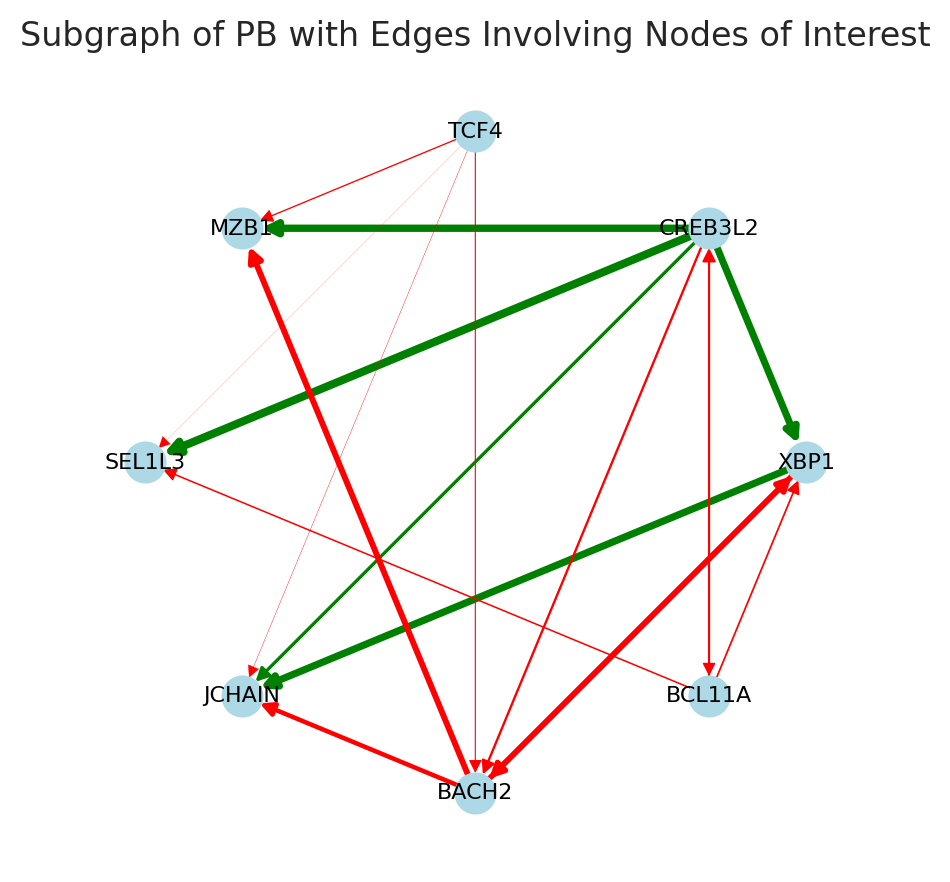

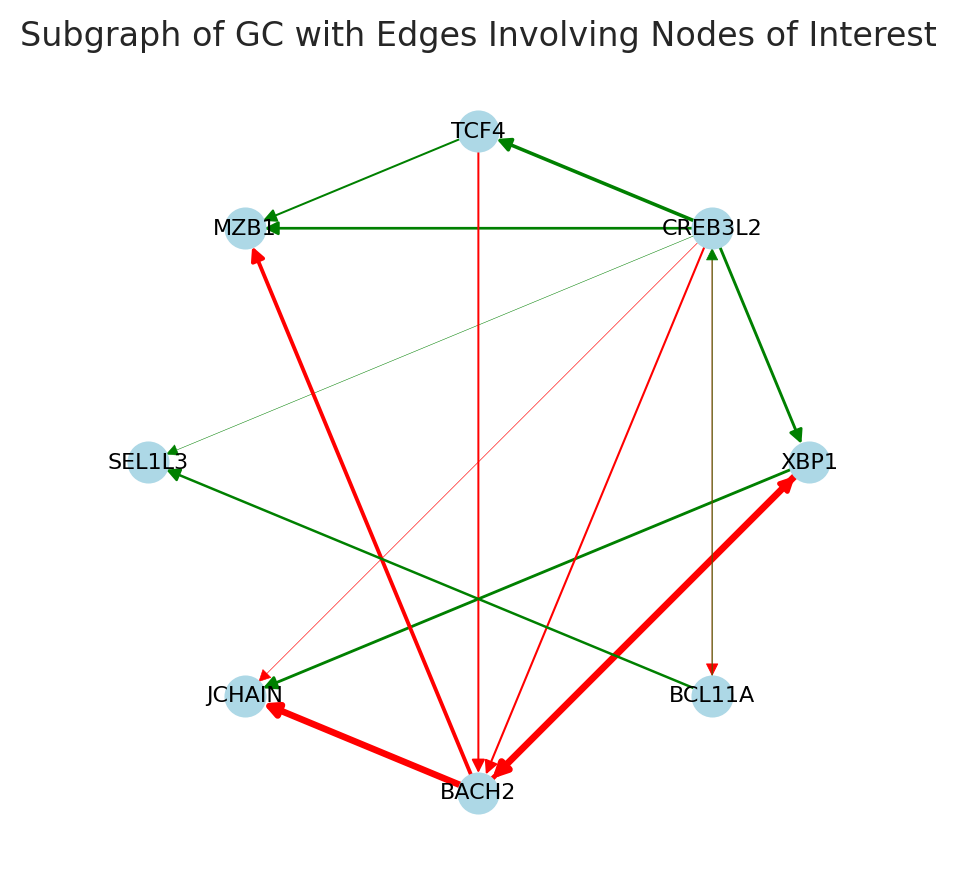

In [72]:
def plot_subgraph(G, nodes_of_interest, title=""):
    subgraph = G.subgraph(nodes_of_interest)

    # Filter edges to include only those connected to nodes of interest
    filtered_edges = [(u, v) for u, v in subgraph.edges() if u in nodes_of_interest or v in nodes_of_interest]

    # Define edge colors based on weight
    edge_colors = ['green' if G[u][v]['weight'] > 0 else 'red' for u, v in filtered_edges]

    # Define edge weights for width
    edge_weights = [8*abs(G[u][v]['weight']) for u, v in filtered_edges]

    # Define positions, placing nodes of interest in the center
    pos = nx.circular_layout(subgraph, center=(0, 0))
    for node,index in enumerate(nodes_of_interest):
        pos[node] = (index, 0)

    # Plot the subgraph with filtered edges and colored nodes
    plt.figure(figsize=(4, 4))
    nx.draw(subgraph, pos, edgelist=filtered_edges, with_labels=True, node_color='lightblue', edge_color=edge_colors, width=edge_weights, node_size=200, font_size=8)
    plt.title(f"Subgraph of {title} with Edges Involving Nodes of Interest")
    plt.show()
    return None

plot_subgraph(G_pb, nodes_of_interest, title='PB')
plot_subgraph(G_gc, nodes_of_interest, title='GC')

In [79]:
with open(f"{out_path}/out_files/moi.pkl", 'wb') as f:
    pickle.dump(moig, f)

# ROUGH BELOW

# Single TF Enrichment

In [13]:
cluster_pairs = [('GC-1','PB-2' ),('PB-2', 'ActB-2'),('GC-1','ActB-2')]
for cluster_pair in cluster_pairs:
    enrichment_df = pd.DataFrame(cc_dict[cluster_pair]['1'], columns=['TF', 'Condition', 'ES', 'Genes'])
    enrichment_df[['Score', 'p_value']] = pd.DataFrame(enrichment_df['ES'].tolist(), index=enrichment_df.index)
    enrichment_df[['common', 'dwnstrm']] = pd.DataFrame(enrichment_df['Genes'].tolist(), index=enrichment_df.index)
    enrichment_df = enrichment_df.drop(columns=['ES', 'Genes'])
    filter_enrichment_df = (enrichment_df['p_value']<1) \
                            & (enrichment_df['dwnstrm'].apply(len)>1) & (enrichment_df['common'].apply(len)>1) \
                            & (enrichment_df['Score']>0) & (enrichment_df['Condition']==(1,))
    enrichment_df = enrichment_df[filter_enrichment_df].sort_values(by='Score', ascending=False)
    enrichment_df.to_csv(f"{out_path}/out_files/SLIDE_LF_enriched_single_TFs.csv", index=False)

    plt.figure(figsize=(10, 6))
    plt.barh(enrichment_df['TF'].apply(lambda x: x[0]), enrichment_df['Score'], color='skyblue')
    plt.xlabel('Enrichment Score')
    plt.ylabel('TFs')
    plt.title(f'Enrichment Score of Single TFs for {cluster_pair}')
    plt.savefig(f"{out_path}/figures/SLIDE_LF_enriched_single_TFs_{cluster_pair}.pdf", dpi=300, bbox_inches='tight')
    plt.close()

# Combinatorial TF Enrichment

In [15]:
for cluster_pair in cluster_pairs:
    enrichment_df = pd.DataFrame(cc_dict[cluster_pair]['2'], columns=['TF', 'Condition', 'ES', 'Genes'])
    enrichment_df[['Score', 'p_value']] = pd.DataFrame(enrichment_df['ES'].tolist(), index=enrichment_df.index)
    enrichment_df[['common', 'dwnstrm']] = pd.DataFrame(enrichment_df['Genes'].tolist(), index=enrichment_df.index)
    enrichment_df = enrichment_df.drop(columns=['ES', 'Genes'])
    filter_enrichment_df = (enrichment_df['p_value']<0.001) \
                            & (enrichment_df['dwnstrm'].apply(len)>1) & (enrichment_df['common'].apply(len)>1) \
                            & (enrichment_df['Score']>0) \
                            & (enrichment_df['Condition'].isin([(1,1), (1,0), (0,1)]))
    enrichment_df = enrichment_df[filter_enrichment_df].sort_values(by='Score', ascending=False)


    tf_of_interest = set(slide_enriched_tfs['TF1_jid']).union(set(slide_enriched_tfs['TF2_jid']))
    motif_name_list = []
    output_file = f"{out_path}/out_files/concatenated_file_{cluster_pair}.txt"
    with open(output_file, 'w') as outfile:
        for tf_id in tf_of_interest:
            if any(tf_id in file for file in os.listdir(search_directory)) or any(tf_id.lower() in file.lower() for file in os.listdir(search_directory)):
                with open(os.path.join(search_directory, file), 'r') as infile:
                    for line in infile:
                        outfile.write(line)
                        if line.startswith('>'):
                            print(line.strip().split('\t')[1])
                            motif_name_list.append(line.strip().split('\t')[1])


    ##### Write file for  CESeek and Cicero based analysis
    # Mapping TF names to JASPAR IDs and writing for downstream analysis
    out_df = enrichment_df.groupby('TF').agg({'Score': 'mean', 'common': lambda x: len(set().union(*x)), 'dwnstrm': lambda x: len(set().union(*x))}).reset_index()
    out_df[['TF1', 'TF2']] = pd.DataFrame(out_df.pop('TF').tolist(), index=out_df.index)
    out_df[['TF1_jid', 'TF2_jid']] = out_df[['TF1', 'TF2']].apply(lambda x: x.str.upper().map(jaspar_dict))
    out_df = out_df.dropna().reset_index(drop=True)
    out_df.to_csv(f"{out_path}/out_files/SLIDE_LF_enriched_TFs_{cluster_pair}.csv", index=False)

In [6]:
cluster_pairs = [('GC-1','PB-2' ),('PB-2', 'ActB-2'),('GC-1','ActB-2')]
cluster_pair = cluster_pairs[0]
actual_TF_pairs = pd.read_csv(f"{out_path}/out_files/SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv")
n = len(actual_TF_pairs)
# create shuffled pairs
shuffled_TF_pairs = pd.DataFrame(columns = ['TF1', 'TF1_jid', 'TF2', 'TF2_jid'])
indices = list(actual_TF_pairs.index)
random.shuffle(indices)
print(indices)
shuffled_TF_pairs[['TF1', 'TF1_jid']] = actual_TF_pairs[['TF1', 'TF1_jid']].iloc[indices].reset_index(drop=True)
random.shuffle(indices)
print(indices)
shuffled_TF_pairs[['TF2', 'TF2_jid']] = actual_TF_pairs[['TF2', 'TF2_jid']].iloc[indices].reset_index(drop=True)
shuffled_TF_pairs.to_csv(f"{out_path}/out_files/shuffled_SLIDE_LF_enriched_double_TFs_{cluster_pair}.csv", index=False)

[37, 32, 95, 84, 2, 23, 82, 1, 62, 18, 92, 7, 9, 28, 43, 42, 73, 22, 15, 12, 38, 36, 27, 94, 75, 40, 14, 69, 10, 21, 35, 30, 101, 34, 47, 89, 16, 17, 5, 6, 64, 86, 87, 44, 0, 13, 88, 31, 99, 77, 46, 81, 56, 102, 54, 41, 59, 52, 11, 29, 67, 60, 91, 57, 48, 66, 20, 55, 58, 68, 50, 51, 39, 33, 74, 96, 25, 71, 8, 45, 98, 19, 76, 100, 78, 80, 61, 65, 53, 85, 49, 90, 72, 97, 26, 83, 24, 79, 70, 4, 63, 3, 93]
[0, 40, 47, 30, 19, 80, 41, 92, 96, 68, 24, 94, 15, 51, 52, 60, 54, 20, 36, 45, 66, 2, 22, 64, 82, 17, 86, 65, 35, 91, 5, 77, 53, 67, 73, 89, 97, 79, 84, 21, 42, 43, 48, 12, 71, 61, 56, 88, 8, 63, 70, 6, 7, 90, 74, 93, 32, 100, 72, 13, 75, 31, 4, 46, 83, 34, 27, 85, 28, 26, 38, 50, 16, 33, 23, 99, 10, 25, 3, 69, 44, 87, 14, 49, 57, 98, 1, 76, 29, 95, 102, 37, 101, 39, 62, 58, 78, 9, 55, 11, 18, 81, 59]


In [7]:
shuffled_TF_pairs

,TF1,TF1_jid,TF2,TF2_jid
0,Creb3l2(MA0608.1),MA0608.1,EBF1(MA0154.5),MA0154.5
1,Creb3l2(MA0608.1),MA0608.1,TFEB(MA0692.2),MA0692.2
2,TFEC(MA0871.3),MA0871.3,IRF4(MA1419.2),MA1419.2
3,SP3(MA0746.3),MA0746.3,NR6A1(MA1541.2),MA1541.2
4,BACH2(MA1470.2),MA1470.2,Creb3l2(MA0608.1),MA0608.1
...,...,...,...,...
98,Nrf1(MA0506.3),MA0506.3,TCF4(MA0830.3),MA0830.3
99,BACH2(MA1470.2),MA1470.2,Creb3l2(MA0608.1),MA0608.1
100,MEF2A(MA0052.5),MA0052.5,BACH2(MA1470.2),MA1470.2
101,BACH2(MA1470.2),MA1470.2,Creb3l2(MA0608.1),MA0608.1


In [8]:
actual_TF_pairs[['TF2', 'TF2_jid']].iloc[indices]

,TF2,TF2_jid
0,EBF1(MA0154.5),MA0154.5
40,TFEB(MA0692.2),MA0692.2
47,IRF4(MA1419.2),MA1419.2
30,NR6A1(MA1541.2),MA1541.2
19,Creb3l2(MA0608.1),MA0608.1
...,...,...
55,TCF4(MA0830.3),MA0830.3
11,Creb3l2(MA0608.1),MA0608.1
18,BACH2(MA1470.2),MA1470.2
81,Creb3l2(MA0608.1),MA0608.1
